<a href="https://colab.research.google.com/github/refercon/ipynb/blob/main/DWSP_MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bias-correction-ucl:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F558095%2F1015285%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240223%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240223T012745Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da8abda1c8adc8d1e6bea55010e227c204d85b30f20d00570b8fc7f0f93c9203fbc3105bbb127b62fd5d8b5fbbacb9ec643275b5f863b2b9409131af350ca495799d027a6369d197865d9c38bbd3952f716bed3afef01d26fa987b5732a520e040896ec3ae3adfcde7abfcf3b83f924ad363e2d52ad85db3cefe40e6d70f560f261e72cc938aaf60f86935a69b4f4a40540fb18c64e076ecd4cd1ab4ce63219fb386011994ecbc52496fa07f1764874f319c680f414bde23f47b64364ac1f951f6c6f380267fcb108090e5fac7f1a6e6d38385ae700f4a12ee39753c3f72669105b89311cf202c8b5f8a65c4f8665c48740144fb4c6116308485e1eb5bcb45837'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 654062 bytes downloaded
Downloaded and uncompressed: bias-correction-ucl
Data source import complete.


# 1. Dataset pre-processing

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import reduce
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('../input/bias-correction-ucl/Bias_correction_ucl.csv')
#df['Worker'] = 'NULL'
df = df.reset_index(drop=True)
df = df.loc[:,['Date','LDAPS_Tmax_lapse','LDAPS_RHmax','LDAPS_CC2','LDAPS_WS','Solar radiation']]
df.columns = ['Location','TEMP','Humidity','Cloud','Wind-speed','SR']
data  = df.groupby('Location')
data_limit_10 = list(data)[0:20]
X = []
for i in range(len(data_limit_10)):
    location = 'L' + str(i + 1)
    data_limit_10[i][1]['Location'] = location
    X.append(data_limit_10)
X2 = []
for j in range(len(data_limit_10)):
    X1 = X[0][j][1].reset_index(drop=True)
    X1.columns = ['Location'+str(j+1),'TEMP'+str(j+1),
                  'Humidity'+str(j+1),'Cloud'+str(j+1),'Wind-speed'+str(j+1),'SR'+str(j+1)]
    X1.index = X1.index + 1
    X1.insert(0, 'Worker', 'GD-W' + X1.index.astype(str))
    X2.append(X1)
# pd.set_option('max_columns',10)
# pd.set_option('max_rows',10)
GD = reduce(lambda left,right: pd.merge(left,right,how='outer',on="Worker"), X2).fillna(method='pad')
GD['Label'] = 1
GD_TEMP = GD.filter(regex='Worker|TEMP')
GD_HUM = GD.filter(regex='Worker|Humidity')
GD_CLD = GD.filter(regex='Worker|Cloud')
GD_CLD.iloc[:,1:21] *= 100
GD_WSD = GD.filter(regex='Worker|Wind-speed')
GD_WSD.iloc[:,1:21] *=  2
GD_SR = GD.filter(regex='Worker|SR')
GD_SR.iloc[:,1:21] /= 100 # (GD_SR.iloc[:,1:21] - GD_SR.iloc[:,1:21].mean()) / GD_SR.iloc[:,1:21].std() #normalization
GD_TEMP.to_csv('gd.csv', index=False)

# 2. Building unknown dataset

---



In [47]:
# 80 workers("AT"， “TPA”, "Spammer")
# There are 10 time-steps in DPC, and DPC arranges 2 locations to workers in 1 time-step.
# 20 “TPA” satisfied accuracy 100% in a specific typle of task.
# 20 "AT" satisfied accuracy ？% in all tasks, but the accuracy is lower in a specific typle of task.
# 40 other workers satisfied distribution randomly.
# 20 “TPA” are generated by GD in a specific typle of task.For example,
# A “TPA” worker submits true data in a typle of TEMP and false data in a typle of humidity, and etc.
# 15 “TPA”  workers has a higher accuracy of single task.  5 workers has a higher accuracy of some tasks.
# 20 "AT" workers has a lower accuracy of single task , but has a higer accuracy of single location.
# 40 other workers: 30 workers satisfied accuracy 100% in a specific typle of task and not all of the time-steps.
# 40 other workers: 10 workers satisfied accuracy 0 in all of the time-steps.

# def font_color(val):
#     print(val)
#     color = 'green' if int(val) == 1 else 'red'
#     return 'color: %s' % color

# .sample(frac=1)
# UNK_workers_TEMP = X3.filter(regex='Worker|TEMP').drop(X3.index.to_list(),axis = 0)
TPA_TEMP = GD_TEMP.reset_index(drop=True).drop(GD_TEMP.tail(5).index).drop('Worker',axis=1)
TPA_HUM = GD_HUM.reset_index(drop=True).drop(GD_HUM.tail(5).index).drop('Worker',axis=1)
TPA_CLD = GD_CLD.reset_index(drop=True).drop(GD_CLD.tail(5).index).drop('Worker',axis=1)
TPA_WSD = GD_WSD.reset_index(drop=True).drop(GD_WSD.tail(5).index).drop('Worker',axis=1)
TPA_SR = GD_SR.reset_index(drop=True).drop(GD_SR.tail(5).index).drop('Worker',axis=1)

TPA_TEMP.index = TPA_TEMP.index + 1
TPA_TEMP.insert(0, 'Worker', 'UN-W' + TPA_TEMP.index.astype(str))
TPA_TEMP.insert(21, 'Label', 0)
TPA_TEMP.loc[0:3,'Label'] = 1
TPA_TEMP.loc[16:20,'Label'] = 1
TPA_TEMP.iloc[3:10,1:],TPA_TEMP.iloc[10:15,1:] = TPA_TEMP.iloc[3:10,1:] * 1.3,TPA_TEMP.iloc[10:15,1:] * 0.7

TPA_HUM.index = TPA_HUM.index + 1
TPA_HUM.insert(0, 'Worker', 'UN-W' + TPA_HUM.index.astype(str))
TPA_HUM.insert(21, 'Label', 0)
TPA_HUM.loc[4:6,'Label'] = 1
TPA_HUM.loc[16:20,'Label'] = 1
TPA_HUM.iloc[0:3,1:],TPA_HUM.iloc[6:15,1:] = TPA_HUM.iloc[0:3,1:] * 1.2,TPA_HUM.iloc[6:15,1:] * 0.8

TPA_CLD.index = TPA_CLD.index + 1
TPA_CLD.insert(0, 'Worker', 'UN-W' + TPA_CLD.index.astype(str))
TPA_CLD.insert(21, 'Label', 0)
TPA_CLD.loc[7:9,'Label'] = 1
TPA_CLD.loc[16:20,'Label'] = 1
TPA_CLD.iloc[0:6,1:],TPA_CLD.iloc[9:15,1:] = TPA_CLD.iloc[0:6,1:] / 3,TPA_CLD.iloc[9:15,1:] / 2

TPA_WSD.index = TPA_WSD.index + 1
TPA_WSD.insert(0, 'Worker', 'UN-W' + TPA_WSD.index.astype(str))
TPA_WSD.insert(21, 'Label', 0)
TPA_WSD.loc[10:12,'Label'] = 1
TPA_WSD.loc[16:20,'Label'] = 1
TPA_WSD.iloc[0:9,1:],TPA_WSD.iloc[12:15,1:] = TPA_WSD.iloc[0:9,1:] * 2,TPA_WSD.iloc[12:15,1:] / 2

TPA_SR.index = TPA_SR.index + 1
TPA_SR.insert(0, 'Worker', 'UN-W' + TPA_SR.index.astype(str))
TPA_SR.insert(21, 'Label', 0)
TPA_SR.loc[13:15,'Label'] = 1
TPA_SR.iloc[0:12,1:],TPA_SR.iloc[15:20,1:] = TPA_SR.iloc[0:12,1:] * 1.2 ,TPA_SR.iloc[15:20,1:] / 1.1

AT_TEMP = TPA_TEMP.append(GD_TEMP.iloc[:20,1:])
AT_TEMP = AT_TEMP.reset_index(drop=True)
AT_TEMP.index = AT_TEMP.index + 1
AT_TEMP.loc[21:40,'Worker'] = 'UN-W' + AT_TEMP.loc[21:40,'Worker'].index.astype(str)
AT_TEMP.loc[21:40,'Label'] = 2
AT_TEMP.iloc[20:40,1:6] = AT_TEMP.iloc[20:40,1:6] * 1.3

AT_HUM = TPA_HUM.append(GD_HUM.iloc[:20,1:])
AT_HUM = AT_HUM.reset_index(drop=True)
AT_HUM.index = AT_HUM.index + 1
AT_HUM.loc[21:40,'Worker'] = 'UN-W' + AT_TEMP.loc[21:40,'Worker'].index.astype(str)
AT_HUM.loc[21:40,'Label'] = 2
AT_HUM.iloc[20:40,1:6],AT_HUM.iloc[20:40,19:21] = AT_HUM.iloc[20:40,1:6] * 1.2,AT_HUM.iloc[20:40,1:6] * .8

AT_CLD = TPA_CLD.append(GD_CLD.iloc[:20,1:])
AT_CLD = AT_CLD.reset_index(drop=True)
AT_CLD.index = AT_CLD.index + 1
AT_CLD.loc[21:40,'Worker'] = 'UN-W' + AT_CLD.loc[21:40,'Worker'].index.astype(str)
AT_CLD.loc[21:40,'Label'] = 2
AT_CLD.iloc[20:40,1:6] = AT_CLD.iloc[20:40,1:6] / 2

AT_WSD = TPA_WSD.append(GD_WSD.iloc[:20,1:])
AT_WSD = AT_WSD.reset_index(drop=True)
AT_WSD.index = AT_WSD.index + 1
AT_WSD.loc[21:40,'Worker'] = 'UN-W' + AT_WSD.loc[21:40,'Worker'].index.astype(str)
AT_WSD.loc[21:40,'Label'] = 2
AT_WSD.iloc[20:40,1:6],AT_WSD.iloc[20:40,19:21] = AT_WSD.iloc[20:40,1:6] * 2,AT_WSD.iloc[20:40,1:6] / 2

AT_SR = TPA_SR.append(GD_SR.iloc[:20,1:])
AT_SR = AT_SR.reset_index(drop=True)
AT_SR.index = AT_SR.index + 1
AT_SR.loc[21:40,'Worker'] = 'UN-W' + AT_SR.loc[21:40,'Worker'].index.astype(str)
AT_SR.loc[21:40,'Label'] = 2
AT_SR.iloc[20:40,1:6],AT_SR.iloc[20:40,19:21] = AT_SR.iloc[20:40,1:6] * 2,AT_SR.iloc[20:40,1:6] / 2

OW_TEMP = AT_TEMP.append(AT_TEMP,ignore_index=True)
OW_TEMP.loc[40:,'Worker'] = 'UN-W' + (OW_TEMP.loc[40:,'Worker'].index +1).astype(str)
OW_TEMP.loc[40:,'Label'] = 0
OW_TEMP.iloc[40:70,1:11] = OW_TEMP.iloc[40:70,1:11] * 1.3
OW_TEMP.iloc[70:80,1:21] = OW_TEMP.iloc[70:80,1:21] * 0.7

OW_HUM = AT_HUM.append(AT_HUM,ignore_index=True)
OW_HUM.loc[40:,'Worker'] = 'UN-W' + (OW_HUM.loc[40:,'Worker'].index +1).astype(str)
OW_HUM.loc[40:,'Label'] = 0
OW_HUM.iloc[40:70,1:11] = OW_HUM.iloc[40:70,1:11] * 1.3
OW_HUM.iloc[70:80,1:21] = OW_HUM.iloc[70:80,1:21] * 0.7

OW_CLD = AT_CLD.append(AT_CLD,ignore_index=True)
OW_CLD.loc[40:,'Worker'] = 'UN-W' + (OW_CLD.loc[40:,'Worker'].index +1).astype(str)
OW_CLD.loc[40:,'Label'] = 0
OW_CLD.iloc[40:70,10:21] = OW_CLD.iloc[40:70,10:21] / 3
OW_CLD.iloc[70:80,1:21] = OW_CLD.iloc[70:80,1:21] / 2

OW_WSD = AT_WSD.append(AT_WSD,ignore_index=True)
OW_WSD.loc[40:,'Worker'] = 'UN-W' + (OW_WSD.loc[40:,'Worker'].index +1).astype(str)
OW_WSD.loc[40:,'Label'] = 0
OW_WSD.iloc[40:70,1:11] = OW_WSD.iloc[40:70,1:11] * 2
OW_WSD.iloc[70:80,1:21] = OW_WSD.iloc[70:80,1:21] / 2

OW_SR = AT_SR.append(AT_SR,ignore_index=True)
OW_SR.loc[40:,'Worker'] = 'UN-W' + (OW_SR.loc[40:,'Worker'].index +1).astype(str)
OW_SR.loc[40:,'Label'] = 0
OW_SR.iloc[40:70,10:21] = OW_SR.iloc[40:70,10:21] * 2
OW_SR.iloc[70:80,1:21] = OW_SR.iloc[70:80,1:21] / 2

# pd.set_option('max_columns',10)
# pd.set_option('max_rows',100)
OW_TEMP
OW_HUM
OW_CLD
OW_WSD
OW_SR

,Worker,SR1,SR2,SR3,SR4,SR5,SR6,SR7,SR8,SR9,...,SR12,SR13,SR14,SR15,SR16,SR17,SR18,SR19,SR20,Label
0,UN-W1,71.914752,71.852625,71.783754,71.708115,71.625709,71.536529,71.440523,71.337346,71.227383,...,70.856537,70.719188,70.574648,70.423160,70.264764,70.099430,69.927105,69.747521,69.560941,0.0
1,UN-W2,70.431750,70.367473,70.296229,70.217994,70.132781,70.040578,69.941332,69.834709,69.721090,...,69.338115,69.196096,69.046998,68.890758,68.727457,68.557025,68.379363,68.194348,68.002219,0.0
2,UN-W3,70.362668,70.298420,70.227217,70.149018,70.063852,69.971695,69.872508,69.765937,69.652377,...,69.269607,69.127916,68.978854,68.822672,68.659424,68.489074,68.311582,68.126684,67.934648,0.0
3,UN-W4,70.283578,70.218902,70.147395,70.069137,69.984387,69.891117,69.791824,69.685588,69.571230,...,69.187916,69.045604,68.896336,68.739797,68.576004,68.405221,68.227371,68.041969,67.849389,0.0
4,UN-W5,70.314627,70.249764,70.177875,70.098938,70.012957,69.919934,69.819809,69.712236,69.597609,...,69.211312,69.068332,68.917916,68.760334,68.595627,68.423771,68.244732,68.058223,67.864535,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,UN-W76,58.613833,58.557529,58.495132,58.426626,58.352017,29.135654,29.092229,29.045586,28.995894,...,28.828489,28.766555,28.701421,28.633198,28.561912,28.487549,28.410100,14.653458,14.639382,0.0
76,UN-W77,58.723765,58.669854,58.610103,58.544492,58.473032,29.197859,29.156250,29.111541,29.063901,...,28.903345,28.843916,28.781396,28.715894,28.647429,28.575994,28.501565,14.680941,14.667463,0.0
77,UN-W78,58.649526,58.594644,58.533818,58.467031,58.394292,29.157795,29.115447,29.069956,29.021487,...,28.858152,28.797705,28.734126,28.667522,28.597913,28.525288,28.449631,14.662382,14.648661,0.0
78,UN-W79,58.935781,58.882671,58.823804,58.759160,58.688750,29.306282,29.265278,29.221208,29.174248,...,29.015964,28.957368,28.895710,28.831106,28.763577,28.693108,28.619680,14.733945,14.720668,0.0


In [48]:
import numpy as np
from cvxopt import matrix, solvers

class detection:
    def __init__(self, nu=0.5, gamma=1):
        self.nu = nu
        self.gamma = gamma
        self.rho = None
        self.alpha = None
        self.X = None

    def gaussian_kernel(self, x, y, gamma):
        return np.exp(-np.sum(np.square(x - y)) / gamma)

    def make_kernel_matrix(self, X, gamma):
        n = X.shape[0]
        Q = np.zeros((n, n))
        q_list = []
        for i in range(n):
            for j in range(i, n):
                q_list.append(self.gaussian_kernel(X[i], X[j], gamma))
        Q_idx = np.triu_indices(len(Q))
        Q[Q_idx] = q_list
        Q = Q.T + Q - np.diag(np.diag(Q))
        return Q

    def fit(self, X):
        nu = self.nu
        gamma = self.gamma
        Q = self.make_kernel_matrix(X, gamma)
        n = X.shape[0]
        P = matrix(Q)
        q = matrix(np.zeros((n, 1)))
        G = matrix(np.vstack([-np.eye(n), np.eye(n)]))
        h = matrix(np.hstack([np.zeros(n), np.ones(n) * (1 / (nu * n))]))
        A = matrix(np.ones((1, n)))
        b = matrix(np.ones(1))

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])

        rho = 0
        alphas = alphas.flatten()
        S = ((alphas > 1e-3) & (alphas < (1 / (nu * n))))
        S_idx = np.where(S)[0]
        for s in S_idx:
            temp_vect = np.array([alphas[i] * self.gaussian_kernel(X[i], X[s], gamma) for i in range(n)])
            rho += np.sum(temp_vect) / np.sum(S)

        self.rho = rho
        self.alphas = alphas
        self.X = X
        return self

    def predict(self, X):
        return np.array([np.sign(self._predict(x)) for x in X])

    def _predict(self, x):
        X = self.X
        n = X.shape[0]
        alphas = self.alphas
        rho = self.rho
        gamma = self.gamma
        temp_vect = np.array([alphas[i] * self.gaussian_kernel(X[i], x, gamma) for i in range(n)])
        decision_val = np.sum(temp_vect) - rho
        return decision_val

In [49]:
X_train = np.array([[10.1], [20], [1], [10], [8], [9]])
X_test = np.array([[210], [1], [8], [10],[12],[13],[13.5],[12.11]])

model = detection(nu=0.5, gamma=0.5).fit(X_train)
model.predict(X_test)

array([-1.,  1.,  1.,  1., -1., -1., -1., -1.])

In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
warnings.filterwarnings('ignore')
GD_TEMP_fit = GD_TEMP.drop('Worker',axis=1)
UN_TEMP_fit = OW_TEMP.drop(['Worker','Label'],axis=1)

GD_HUM_fit = GD_HUM.drop('Worker',axis=1)
UN_HUM_fit = OW_HUM.drop(['Worker','Label'],axis=1)

GD_CLD_fit = GD_CLD.drop('Worker',axis=1)
UN_CLD_fit = OW_CLD.drop(['Worker','Label'],axis=1)

GD_WSD_fit = GD_WSD.drop('Worker',axis=1)
UN_WSD_fit = OW_WSD.drop(['Worker','Label'],axis=1)

GD_SR_fit = GD_SR.drop('Worker',axis=1)
UN_SR_fit = OW_SR.drop(['Worker','Label'],axis=1)

search_params = pd.DataFrame(columns=['nu', 'gamma', 'GD_ACC', 'GD_F1score', 'Test_ACC', 'Test_F1score'])
# 定义参数搜索范围
nus = np.linspace(0.01, 0.99, 99)  # nu 参数的搜索范围
gammas = [0.1, 0.5, 1]  # gamma 参数的搜索范围

i = 0
for nu in nus:
    for gamma in gammas:
        estimator = detection(nu=nu, gamma=gamma)
        GD_temp_shuffle = GD_TEMP_fit.iloc[:,0:2].sample(frac=1)
        UN_temp_shuffle = UN_TEMP_fit.iloc[:,0:2]
        estimator.fit(GD_temp_shuffle.values)
        y_pred_temp_gd = estimator.predict(GD_temp_shuffle.values)
        y_pred_temp = estimator.predict(UN_temp_shuffle.values)
        for j in range(len(OW_TEMP.loc[0:19,'Label'])):
          if OW_TEMP.loc[0:19,'Label'][j] != 1:
              OW_TEMP.loc[0:19,'Label'][j] = -1
        # 计算性能指标
        gd_acc = accuracy_score(GD.loc[0:19,'Label'], y_pred_temp_gd[0:20])
        gd_f1 = f1_score(GD.loc[0:19,'Label'], y_pred_temp_gd[0:20])
        test_acc = accuracy_score(OW_TEMP.loc[0:19,'Label'], y_pred_temp[0:20])
        test_f1 = f1_score(OW_TEMP.loc[0:19,'Label'], y_pred_temp[0:20])

        # 记录结果
        search_params = search_params.append({'nu': nu, 'gamma': gamma, 'GD_ACC': gd_acc, 'GD_F1score': gd_f1, 'Test_ACC': test_acc, 'Test_F1score': test_f1}, ignore_index=True)

        i += 1

# 显示或保存搜索结果
search_params

,nu,gamma,GD_ACC,GD_F1score,Test_ACC,Test_F1score
0,0.01,0.1,0.25,0.400000,0.60,0.000000
1,0.01,0.5,0.60,0.750000,0.75,0.545455
2,0.01,1.0,0.80,0.888889,0.85,0.769231
3,0.02,0.1,0.30,0.461538,0.60,0.000000
4,0.02,0.5,0.60,0.750000,0.75,0.545455
...,...,...,...,...,...,...
292,0.98,0.5,0.55,0.709677,0.70,0.400000
293,0.98,1.0,0.50,0.666667,0.75,0.545455
294,0.99,0.1,0.75,0.857143,0.75,0.545455
295,0.99,0.5,0.60,0.750000,0.75,0.545455


# **3. Data classfication**

In [51]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.svm import OneClassSVM as detection
from IPython.display import display
warnings.filterwarnings('ignore')
GD_TEMP_fit = GD_TEMP.drop('Worker',axis=1)
UN_TEMP_fit = OW_TEMP.drop(['Worker','Label'],axis=1)

GD_HUM_fit = GD_HUM.drop('Worker',axis=1)
UN_HUM_fit = OW_HUM.drop(['Worker','Label'],axis=1)

GD_CLD_fit = GD_CLD.drop('Worker',axis=1)
UN_CLD_fit = OW_CLD.drop(['Worker','Label'],axis=1)

GD_WSD_fit = GD_WSD.drop('Worker',axis=1)
UN_WSD_fit = OW_WSD.drop(['Worker','Label'],axis=1)

GD_SR_fit = GD_SR.drop('Worker',axis=1)
UN_SR_fit = OW_SR.drop(['Worker','Label'],axis=1)


search_params = pd.DataFrame({'nus':[0],'GD_ACC':[0],'GD_F1score':[0],'Test_ACC':[0],'Test_F1score':[0]})
nus = 0
i = 0
while nus <= 0.99:
    nus += 0.01
    i += 1
    estimator= detection(nu=nus, kernel="rbf", gamma=0.01)
#     for t in range(20):
#         if t % 2 == 0:
    GD_temp_shuffle = GD_TEMP_fit.iloc[:,0:2].sample(frac=1)
    UN_temp_shuffle = UN_TEMP_fit.iloc[:,0:2]
    estimator.fit(GD_temp_shuffle)
    y_pred_temp_gd = estimator.predict(GD_temp_shuffle)
    y_pred_temp = estimator.predict(UN_temp_shuffle)
#     TEMP = OW_TEMP.loc[:,['Worker','TEMP'+str(t + 1),'TEMP'+str(t + 2)]]
#     predict_TEMP.append(TEMP[y_pred_temp==1])
    for j in range(len(OW_TEMP.loc[0:19,'Label'])):
        if OW_TEMP.loc[0:19,'Label'][j] != 1:
            OW_TEMP.loc[0:19,'Label'][j] = -1
    search_params.loc[i] = [nus,accuracy_score(GD.loc[0:19,'Label'],y_pred_temp_gd[0:20]),
                            f1_score(GD.loc[0:19,'Label'],y_pred_temp_gd[0:20]),
                            accuracy_score(OW_TEMP.loc[0:19,'Label'],y_pred_temp[0:20]),
                            f1_score(OW_TEMP.loc[0:19,'Label'],y_pred_temp[0:20])]
search_params.drop([0])

,nus,GD_ACC,GD_F1score,Test_ACC,Test_F1score
1,0.01,1.00,1.000000,1.0,1.0
2,0.02,1.00,1.000000,1.0,1.0
3,0.03,1.00,1.000000,1.0,1.0
4,0.04,1.00,1.000000,1.0,1.0
5,0.05,1.00,1.000000,1.0,1.0
...,...,...,...,...,...
95,0.95,0.05,0.095238,0.6,0.0
96,0.96,0.00,0.000000,0.6,0.0
97,0.97,0.00,0.000000,0.6,0.0
98,0.98,0.00,0.000000,0.6,0.0


In [52]:
import time
start_time = time.time()
end_time = time.time()

from sklearn.metrics import accuracy_score,f1_score
import warnings
import matplotlib.pyplot  as plt
from IPython.display import display
warnings.filterwarnings('ignore')
vars()['GT_fit'] = [GD_TEMP.drop('Worker',axis=1),GD_HUM.drop('Worker',axis=1),GD_CLD.drop('Worker',axis=1),GD_WSD.drop('Worker',axis=1),
                    GD_SR.drop('Worker',axis=1)]
vars()['UN_fit'] = [OW_TEMP.drop(['Worker','Label'],axis=1),OW_HUM.drop(['Worker','Label'],axis=1),
                    OW_CLD.drop(['Worker','Label'],axis=1),OW_WSD.drop(['Worker','Label'],axis=1),
                    OW_SR.drop(['Worker','Label'],axis=1)]
vars()['reliable'] = [[],[],[],[],[]]
vars()['unreliable'] = [[],[],[],[],[]]
task = ['TEMP','Humidity','Cloud','Wind-speed','SR']
vars()['ACC'] = [pd.DataFrame({'Task':[0],'Cycle':[0],'ACC':[0],'F1-score':[0]}),
                 pd.DataFrame({'Task':[0],'Cycle':[0],'ACC':[0],'F1-score':[0]}),
                 pd.DataFrame({'Task':[0],'Cycle':[0],'ACC':[0],'F1-score':[0]}),
                 pd.DataFrame({'Task':[0],'Cycle':[0],'ACC':[0],'F1-score':[0]}),
                 pd.DataFrame({'Task':[0],'Cycle':[0],'ACC':[0],'F1-score':[0]})]

vars()['OW'] = [OW_TEMP,OW_HUM,OW_CLD,OW_WSD,OW_SR]
estimator= detection(nu=0.01, kernel="rbf", gamma=0.01)
for f in range(len(vars()['reliable'])):
    for t in range(20):
        if t % 2 == 0:
            estimator.fit(GT_fit[f].iloc[:,t:t+2])
            y_pred_temp = estimator.predict(UN_fit[f].iloc[:,t:t + 2])
            reliable[f].append(OW[f].loc[:,['Worker',task[f]+str(t + 1),task[f]+str(t + 2)]][y_pred_temp==1])
            unreliable[f].append(OW[f].loc[:,['Worker',task[f]+str(t + 1),task[f]+str(t + 2)]][y_pred_temp==-1])#-1 unlabelled..
            for i in range(len(OW[f].loc[0:19,'Label'])):
                if OW[f].loc[0:19,'Label'][i] != 1:
                    OW[f].loc[0:19,'Label'][i] = -1
            ACC[f].loc[int(t/2)] = [task[f],'t'+str(int(t/2 + 1)),accuracy_score(OW[f].loc[0:19,'Label'],y_pred_temp[0:20]),
                                    f1_score(OW[f].loc[0:19,'Label'],y_pred_temp[0:20])]

execution_time = end_time - start_time
print("程序执行时间：", execution_time, "秒")


# pd.set_option('max_columns',20)
# pd.set_option('max_rows',20)

ACC[0].merge(ACC[1].merge(ACC[2].merge(ACC[3].merge(ACC[4],on="Cycle"),on="Cycle"),on="Cycle"),on="Cycle")

# unreliable_all = []
# for i in range(len(vars()['unreliable'])):
#     for j in range(10):
#         unreliable_all.append(unreliable[i][j])

# unreliable_all = reduce(lambda left,right: pd.merge(left,right,how='outer',on="Worker"),unreliable_all)
# unreliable_all

#分类效果图

程序执行时间： 3.075599670410156e-05 秒


,Task,Cycle,ACC,F1-score,Task_x,ACC_x,F1-score_x,Task_y,ACC_y,F1-score_y,Task_x,ACC_x,F1-score_x,Task_y,ACC_y,F1-score_y
0,TEMP,t1,1.00,1.000000,Humidity,1.00,1.000000,Cloud,1.00,1.000000,Wind-speed,0.90,0.857143,SR,1.0,1.0
1,TEMP,t2,0.95,0.933333,Humidity,0.95,0.933333,Cloud,0.95,0.933333,Wind-speed,1.00,1.000000,SR,1.0,1.0
2,TEMP,t3,0.95,0.933333,Humidity,1.00,1.000000,Cloud,0.90,0.857143,Wind-speed,1.00,1.000000,SR,1.0,1.0
3,TEMP,t4,1.00,1.000000,Humidity,1.00,1.000000,Cloud,0.95,0.933333,Wind-speed,0.95,0.933333,SR,1.0,1.0
4,TEMP,t5,0.95,0.933333,Humidity,1.00,1.000000,Cloud,0.95,0.933333,Wind-speed,0.95,0.933333,SR,1.0,1.0
5,TEMP,t6,0.95,0.933333,Humidity,1.00,1.000000,Cloud,0.95,0.933333,Wind-speed,0.95,0.933333,SR,1.0,1.0
6,TEMP,t7,0.95,0.933333,Humidity,1.00,1.000000,Cloud,1.00,1.000000,Wind-speed,0.90,0.857143,SR,1.0,1.0
7,TEMP,t8,0.95,0.933333,Humidity,1.00,1.000000,Cloud,0.90,0.857143,Wind-speed,0.90,0.857143,SR,1.0,1.0
8,TEMP,t9,0.90,0.857143,Humidity,1.00,1.000000,Cloud,0.95,0.933333,Wind-speed,1.00,1.000000,SR,1.0,1.0
9,TEMP,t10,1.00,1.000000,Humidity,0.90,0.857143,Cloud,0.95,0.933333,Wind-speed,0.95,0.933333,SR,1.0,1.0


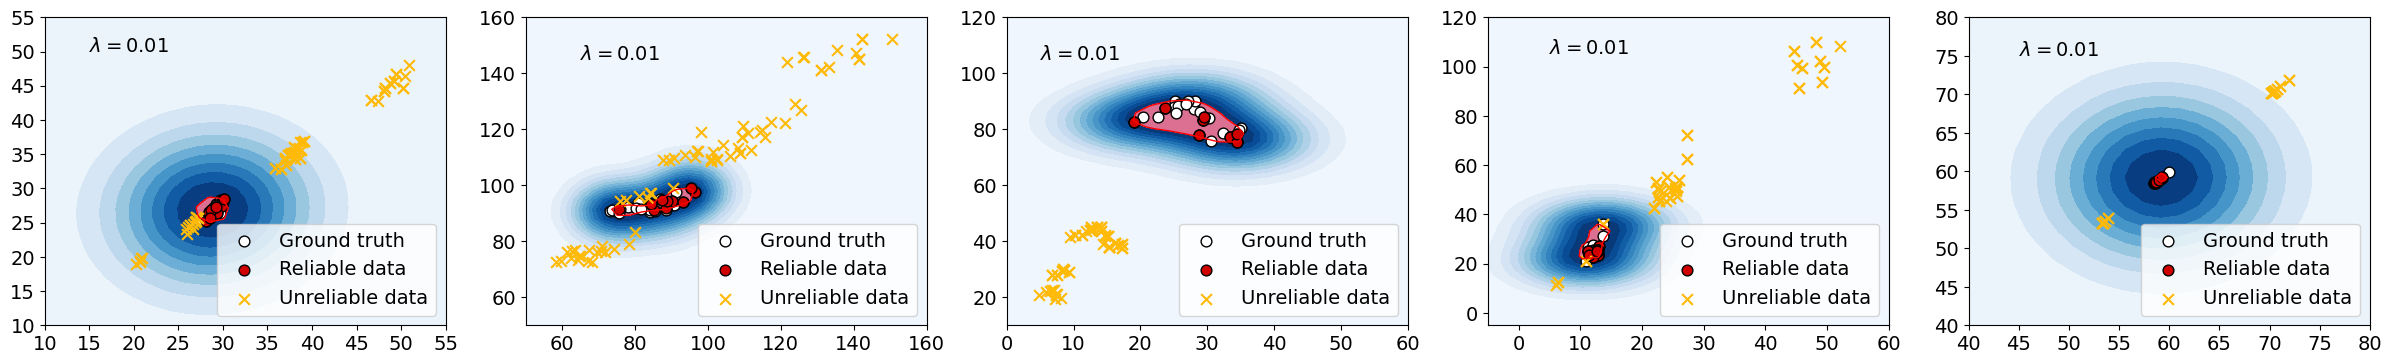

,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20
0,28.074101,25.276716,27.785497,28.125651,30.458252,29.855779,28.228053,25.854402,25.368281,27.872808,24.812107,23.356801,24.078120,24.408651,28.231726,25.554760,27.052255,25.063962,29.195536,28.049941
1,29.850689,27.437523,30.191114,30.353741,32.353385,31.801526,29.967543,27.790189,27.771540,30.262762,27.086121,24.905254,25.493415,26.072713,30.322133,27.320412,29.320542,26.989545,31.511810,30.563332
2,30.091292,28.378123,31.099859,30.923613,33.172049,32.683057,30.467928,28.415396,28.342721,30.809077,27.837535,25.542354,25.725137,26.474784,30.713840,27.838485,30.170466,27.466069,32.082534,31.280418
3,29.704629,26.444996,29.505267,30.214548,32.115017,31.235638,29.719483,27.193201,27.986173,30.332290,26.760240,24.842995,25.820976,25.952824,30.032792,26.851137,28.842677,26.959410,30.744067,29.846308
4,29.113934,27.011573,29.662866,29.871706,31.649599,31.400385,29.432474,28.166002,27.850513,30.512891,27.548554,24.816114,25.829121,26.653585,29.969377,26.876534,28.638667,26.689430,30.710893,30.213920
5,29.219342,27.680824,30.085190,30.172644,32.782449,31.800134,29.679678,28.172758,27.919144,30.569197,28.056509,25.465980,25.828952,26.868445,30.221667,27.499426,28.874300,27.041324,31.421642,30.749292
6,28.551859,26.432668,27.290923,27.913488,30.616892,29.081097,28.977550,26.935678,26.434606,28.052001,25.699058,24.434553,24.874270,25.734883,29.049506,26.807639,26.946966,26.584094,29.745666,28.871287
7,28.851982,26.905715,28.764731,29.253065,32.292559,30.466283,29.346776,27.696185,27.311138,29.694475,27.302889,24.591550,25.228457,26.605364,30.108989,27.266582,28.117635,27.162298,31.116422,30.187373
8,28.426975,26.212910,27.906811,28.175518,30.754932,29.107393,28.698631,26.903767,26.532462,28.391205,26.037734,24.149234,24.775297,26.043637,29.318970,26.858132,27.438039,26.661931,30.118615,29.144791
9,27.576705,25.393791,27.976726,28.392311,31.212291,29.556447,28.073368,26.550039,26.391030,29.206143,26.320968,23.706482,24.322247,25.512805,29.022784,26.038309,26.768150,25.691064,30.005019,29.144612


In [53]:
#Visualize the process of training and predicting.
plt.figure(figsize = (30,4))
size = 14
plt.subplot(151) #Temperature
time_step1 = 0
time_step2 = 2
lam=0.01
estimator= detection(nu=lam, kernel="rbf", gamma=0.01)

estimator.fit(GT_fit[0].iloc[:,time_step1:time_step2])
predict_0 = estimator.predict(UN_fit[0].iloc[:,time_step1:time_step2])
reliable_pre = UN_fit[0].iloc[:,time_step1:time_step2][predict_0==1]
unreliable_pre = UN_fit[0].iloc[:,time_step1:time_step2][predict_0==-1]

xx, yy = np.meshgrid(np.linspace(0, 70, 50), np.linspace(0, 70, 50))
Z = estimator.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

a = plt.scatter(GT_fit[0].iloc[:,time_step1:time_step1+1], GT_fit[0].iloc[:,time_step1+1:time_step2], c='white', s=60, edgecolors='k', marker='o')
b = plt.scatter(reliable_pre.iloc[:,0:1], reliable_pre.iloc[:,1:2], c='#D00000', s=60,edgecolors='k', marker='o')
c = plt.scatter(unreliable_pre.iloc[:,0:1], unreliable_pre.iloc[:,1:2],  c='#FFBA08', edgecolor='k', s=60, marker='x')
plt.axis('tight')
plt.xlim((10, 55))
plt.ylim((10, 55))
plt.xticks(size=size)
plt.yticks(size=size)
plt.text(15,50, f'$\lambda={lam}$',fontsize=size)
plt.legend([a, b, c],[ "Ground truth","Reliable data", "Unreliable data"],loc="lower right", prop={'size': size})
# plt.xlabel('X1',fontsize=15)
# plt.ylabel('X2',fontsize=15)
# plt.grid(linestyle=":")

plt.subplot(152)#Humidity
estimator.fit(GT_fit[1].iloc[:,time_step1:time_step2])
predict_1 = estimator.predict(UN_fit[1].iloc[:,time_step1:time_step2])
reliable_pre = UN_fit[1].iloc[:,time_step1:time_step2][predict_1==1]
unreliable_pre = UN_fit[1].iloc[:,time_step1:time_step2][predict_1==-1]
xx, yy = np.meshgrid(np.linspace(0, 160, 50), np.linspace(0, 160, 50))
Z = estimator.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 15), cmap=plt.cm.Blues)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

a = plt.scatter(GT_fit[1].iloc[:,time_step1:time_step1+1], GT_fit[1].iloc[:,time_step1+1:time_step2], c='white', s=60, edgecolors='k', marker='o')
b = plt.scatter(reliable_pre.iloc[:,0:1], reliable_pre.iloc[:,1:2], c='#D00000', s=60,edgecolors='k', marker='o')
c = plt.scatter(unreliable_pre.iloc[:,0:1], unreliable_pre.iloc[:,1:2],  c='#FFBA08', edgecolor='k', s=60, marker='x')
plt.axis('tight')
plt.xlim((50, 160))
plt.ylim((50, 160))
plt.xticks(size=size)
plt.yticks(size=size)
plt.text(65,145, f'$\lambda={lam}$',fontsize=size)
plt.legend([a, b, c],[ "Ground truth","Reliable data", "Unreliable data"],loc="lower right", prop={'size': size})
# plt.xlabel('X1',fontsize=15)
# plt.ylabel('X2',fontsize=15)
# plt.grid(linestyle=":")

plt.subplot(153)#Cloud
estimator.fit(GT_fit[2].iloc[:,time_step1:time_step2])
predict_2 = estimator.predict(UN_fit[2].iloc[:,time_step1:time_step2])
reliable_pre = UN_fit[2].iloc[:,time_step1:time_step2][predict_2==1]
unreliable_pre = UN_fit[2].iloc[:,time_step1:time_step2][predict_2==-1]
xx, yy = np.meshgrid(np.linspace(0, 120, 50), np.linspace(0, 120, 50))
Z = estimator.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 15), cmap=plt.cm.Blues)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
a = plt.scatter(GT_fit[2].iloc[:,time_step1:time_step1+1], GT_fit[2].iloc[:,time_step1+1:time_step2], c='white', s=60, edgecolors='k', marker='o')
b = plt.scatter(reliable_pre.iloc[:,0:1], reliable_pre.iloc[:,1:2], c='#D00000', s=60,edgecolors='k', marker='o')
c = plt.scatter(unreliable_pre.iloc[:,0:1], unreliable_pre.iloc[:,1:2],  c='#FFBA08', edgecolor='k', s=60, marker='x')
plt.axis('tight')
plt.text(5,105, f'$\lambda={lam}$',fontsize=size)
plt.xlim((0, 60))
plt.ylim((10, 120))
plt.xticks(size=size)
plt.yticks(size=size)
plt.legend([a, b, c],[ "Ground truth","Reliable data", "Unreliable data"],loc="lower right", prop={'size': size})
# plt.xlabel('X1',fontsize=15)
# plt.ylabel('X2',fontsize=15)
# plt.grid(linestyle=":")

plt.subplot(154)#Wind-speed
estimator.fit(GT_fit[3].iloc[:,time_step1:time_step2])
predict_3 = estimator.predict(UN_fit[3].iloc[:,time_step1:time_step2])
reliable_pre = UN_fit[3].iloc[:,time_step1:time_step2][predict_3==1]
unreliable_pre = UN_fit[3].iloc[:,time_step1:time_step2][predict_3==-1]
xx, yy = np.meshgrid(np.linspace(-5, 120, 50), np.linspace(-5, 120, 50))
Z = estimator.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 15), cmap=plt.cm.Blues)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
a = plt.scatter(GT_fit[3].iloc[:,time_step1:time_step1+1], GT_fit[3].iloc[:,time_step1+1:time_step2], c='white', s=60, edgecolors='k', marker='o')
b = plt.scatter(reliable_pre.iloc[:,0:1], reliable_pre.iloc[:,1:2], c='#D00000', s=60,edgecolors='k', marker='o')
c = plt.scatter(unreliable_pre.iloc[:,0:1], unreliable_pre.iloc[:,1:2],  c='#FFBA08', edgecolor='k', s=60, marker='x')
plt.text(5,105,  f'$\lambda={lam}$',fontsize=14)
plt.axis('tight')
plt.xlim((-5, 60))
plt.ylim((-5, 120))
plt.xticks(size=size)
plt.yticks(size=size)
plt.legend([a, b, c],[ "Ground truth","Reliable data", "Unreliable data"],loc="lower right", prop={'size': size})
# plt.xlabel('X1',fontsize=15)
# plt.ylabel('X2',fontsize=15)
# plt.grid(linestyle=":")

plt.subplot(155)#Solar-radiation
estimator.fit(GT_fit[4].iloc[:,time_step1:time_step2])
predict_4 = estimator.predict(UN_fit[4].iloc[:,0:2])
reliable_pre = UN_fit[4].iloc[:,time_step1:time_step2][predict_4==1]
unreliable_pre = UN_fit[4].iloc[:,time_step1:time_step2][predict_4==-1]
xx, yy = np.meshgrid(np.linspace(-5, 80, 50), np.linspace(-5, 80, 50))
Z = estimator.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues)
plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
a = plt.scatter(GT_fit[4].iloc[:,time_step1:time_step1+1], GT_fit[4].iloc[:,time_step1+1:time_step2], c='white', s=60, edgecolors='k', marker='o')
b = plt.scatter(reliable_pre.iloc[:,0:1], reliable_pre.iloc[:,1:2], c='#D00000', s=60,edgecolors='k', marker='o')
c = plt.scatter(unreliable_pre.iloc[:,0:1], unreliable_pre.iloc[:,1:2], c='#FFBA08',edgecolor='k', s=60, marker='x')
plt.text(45,75, f'$\lambda={lam}$',fontsize=size)
plt.axis('tight')
plt.xlim((40, 80))
plt.ylim((40, 80))
plt.xticks(size=size)
plt.yticks(size=size)
plt.legend([a, b, c],[ "Ground truth","Reliable data", "Unreliable data"],loc="lower right", prop={'size': size})
# plt.xlabel('X1',fontsize=15)
# plt.ylabel('X2',fontsize=15)
# plt.grid(linestyle=":")
plt.savefig(f'{lam}.svg',dpi=600,bbox_inches = 'tight')
plt.show()
GT_fit[0]

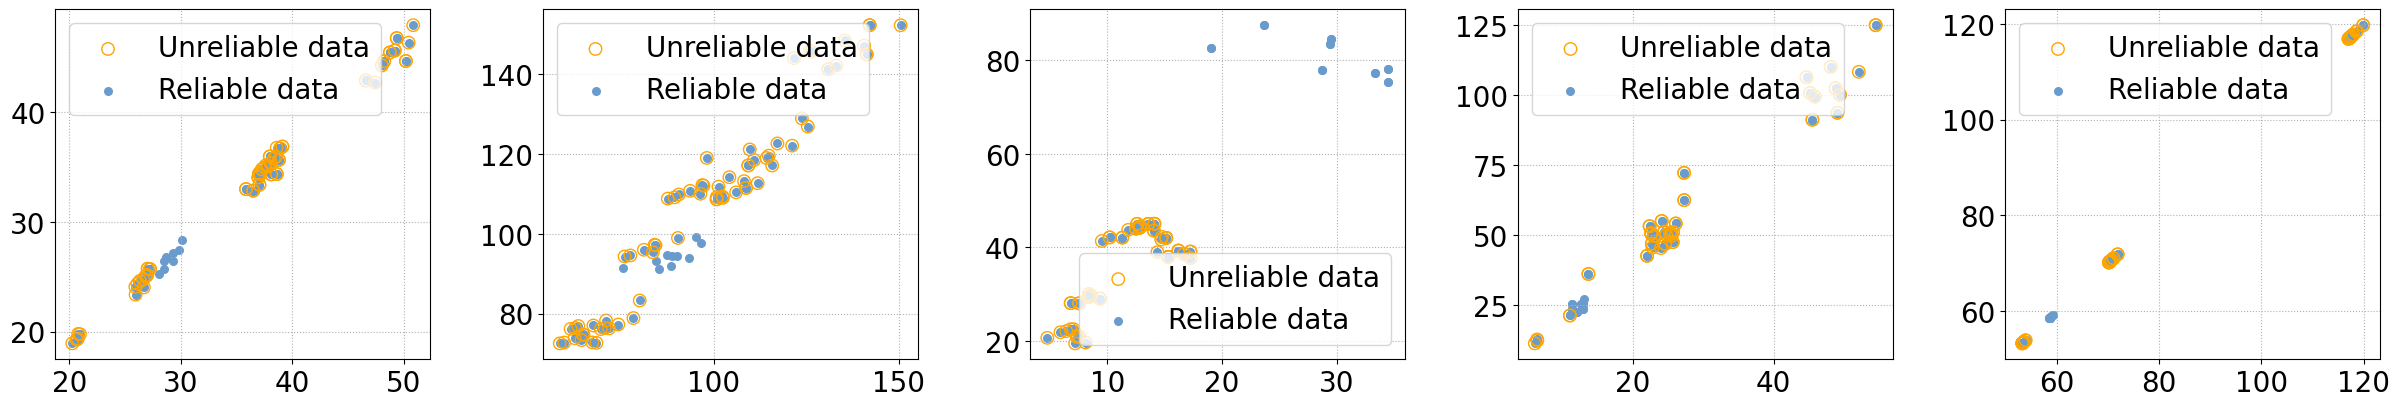

In [54]:
font1 = {
'weight' : 'normal',
'size' : 20,
}
fontsize = 20
size = 14
plt.figure(figsize = (30,10))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3)
plt.subplot(251)
original_data = plt.scatter(UN_fit[0].iloc[:,0:1],UN_fit[0].iloc[:,1:2],marker=".",facecolor='#699BCD',s=120)
abnomal_data = plt.scatter(UN_fit[0].iloc[:,0:1][predict_0==-1],UN_fit[0].iloc[:,1:2][predict_0==-1],
                           marker="o",facecolor='none',edgecolors='orange',s=80)
plt.legend((abnomal_data,original_data),('Unreliable data',
                                         'Reliable data'),prop=font1)
plt.grid(linestyle=':')
plt.tick_params(labelsize=fontsize)

plt.subplot(252)
original_data = plt.scatter(UN_fit[1].iloc[:,0:1],UN_fit[1].iloc[:,1:2],marker=".",facecolor='#699BCD',s=120)
abnomal_data = plt.scatter(UN_fit[1].iloc[:,0:1][predict_1==-1],UN_fit[1].iloc[:,1:2][predict_1==-1],
                           marker="o",facecolor='none',edgecolors='orange',s=80)
plt.legend((abnomal_data,original_data),('Unreliable data',
                                         'Reliable data'),prop=font1)
plt.grid(linestyle=':')
plt.tick_params(labelsize=fontsize)

plt.subplot(253)
original_data = plt.scatter(UN_fit[2].iloc[:,0:1],UN_fit[2].iloc[:,1:2],marker=".",facecolor='#699BCD',s=120)
abnomal_data = plt.scatter(UN_fit[2].iloc[:,0:1][predict_2==-1],UN_fit[2].iloc[:,1:2][predict_2==-1],
                           marker="o",facecolor='none',edgecolors='orange',s=80)
plt.legend((abnomal_data,original_data),('Unreliable data',
                                         'Reliable data'),prop=font1,loc="lower right")
plt.grid(linestyle=':')
plt.tick_params(labelsize=fontsize)

plt.subplot(254)#Postive data distribution
original_data = plt.scatter(UN_fit[3].iloc[:,0:1],UN_fit[3].iloc[:,1:2],marker=".",facecolor='#699BCD',s=120)
abnomal_data = plt.scatter(UN_fit[3].iloc[:,0:1][predict_3==-1],UN_fit[3].iloc[:,1:2][predict_3==-1],
                           marker="o",facecolor='none',edgecolors='orange',s=80)

plt.legend((abnomal_data,original_data),('Unreliable data',
                                         'Reliable data'),prop=font1,loc="upper left")
plt.grid(linestyle=':')
plt.tick_params(labelsize=fontsize)

plt.subplot(255)#Postive data distribution
original_data = plt.scatter(UN_fit[4].iloc[:,0:1],UN_fit[4].iloc[:,1:2],marker=".",facecolor='#699BCD',s=120)
abnomal_data = plt.scatter(UN_fit[4].iloc[:,0:1][predict_4==-1],UN_fit[4].iloc[:,1:2][predict_4==-1],
                           marker="o",facecolor='none',edgecolors='orange',s=80)

plt.legend((abnomal_data,original_data),('Unreliable data',
                                         'Reliable data'),prop=font1)
plt.grid(linestyle=':')
plt.tick_params(labelsize=fontsize)

plt.savefig('1-1.svg',dpi=600,bbox_inches = 'tight')
plt.show()


[0. 0. 1.] , [0. 1. 1.]
[0. 0. 1.] , [0. 1. 1.]
[0. 0. 1.] , [0. 1. 1.]
[0. 0. 1.] , [0.   0.75 1.  ]
[0. 0. 1.] , [0. 1. 1.]


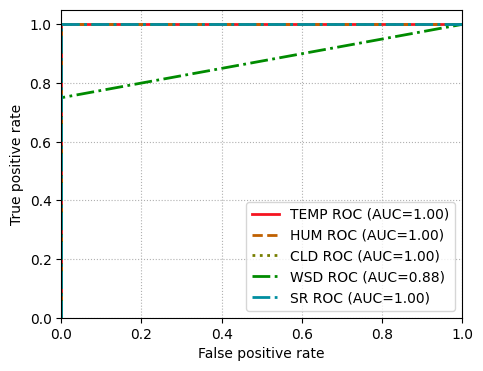

In [55]:
import sklearn as skl
import matplotlib.pyplot as plt
from cycler import cycler
plt.figure(figsize = (30,4))
plt.rc('axes', prop_cycle=(cycler('color', ['#F51420','#C06000','#777E00','#008B00', '#008EA0']) +
                           cycler('linestyle', ['-', '--', ':', '-.', '-.'])))

def plot_roc(t,y_test, y_pred,subsize,label_postion="lower right"):
    fpr, tpr, thresholds = skl.metrics.roc_curve(y_test, y_pred, pos_label=1)
    print(fpr,',', tpr)

    roc_auc = skl.metrics.auc(fpr, tpr)
    lw = 2
    plt.subplot(1,5,subsize)
    plt.plot(fpr, tpr, lw=lw, label=t+' ROC (AUC={0:.2f})'.format(roc_auc))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc=label_postion)
    plt.grid(linestyle=":")

plot_roc('TEMP',OW[0].loc[0:19,'Label'], predict_0[0:20],1)
plot_roc('HUM',OW[1].loc[0:19,'Label'], predict_1[0:20],1)
plot_roc('CLD',OW[2].loc[0:19,'Label'], predict_2[0:20],1)
plot_roc('WSD',OW[3].loc[0:19,'Label'], predict_3[0:20],1)
plot_roc('SR',OW[4].loc[0:19,'Label'], predict_4[0:20],1)
plt.savefig('2.svg',dpi=600,bbox_inches = 'tight')
plt.show()

# 4. Calculate trust according to the reliable data

In [56]:
import time
start_time = time.time()
end_time = time.time()
# pd.set_option('max_columns',10)
# pd.set_option('max_rows',10)
vars()['reliable'] = [reliable[0],reliable[1],reliable[2],reliable[3],reliable[4]]
task = ['TEMP','Humidity','Cloud','Wind-speed','SR']
for i in range(len(vars()['reliable'])):
    vars()['reliable_trust_'+str(i)] = reduce(lambda left,right: pd.merge(left,right,how='outer',on="Worker"), reliable[i]).fillna(0)
    vars()['reliable_trust_'+str(i)]['Correct'] = 0.00
    for j in range(len( vars()['reliable_trust_'+str(i)])):
        m = 0
        for k in range(20):
            if  vars()['reliable_trust_'+str(i)][task[i]+str(k+1)][j] > 0:
                m = m + 1
        vars()['reliable_trust_'+str(i)]['Correct'][j] = m / 20
execution_time = end_time - start_time
print("程序执行时间：", execution_time, "秒")
reliable_trust_0

程序执行时间： 8.845329284667969e-05 秒


,Worker,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,...,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,Correct
0,UN-W1,28.074101,25.276716,27.785497,28.125651,30.458252,29.855779,28.228053,25.854402,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.195536,28.049941,0.5
1,UN-W2,29.850689,27.437523,30.191114,30.353741,32.353385,31.801526,29.967543,27.790189,27.771540,...,24.905254,25.493415,26.072713,30.322133,27.320412,29.320542,26.989545,31.511810,30.563332,1.0
2,UN-W3,30.091292,28.378123,0.000000,0.000000,0.000000,0.000000,30.467928,28.415396,28.342721,...,25.542354,25.725137,26.474784,30.713840,27.838485,0.000000,0.000000,32.082534,31.280418,0.7
3,UN-W16,28.476517,26.483785,29.213197,29.617754,31.938089,30.559271,29.167366,27.896346,27.768703,...,25.024165,25.566064,26.694270,30.127441,27.210091,27.903310,26.677616,30.818777,30.303568,1.0
4,UN-W17,29.321525,26.425377,29.821867,30.135355,32.032467,31.401295,29.651414,27.593128,27.689295,...,24.537425,25.387851,26.026215,30.035034,26.793552,28.910685,26.660877,30.820221,30.041732,1.0
5,UN-W18,28.676175,26.779854,29.574797,29.866667,32.179787,31.006587,29.378685,28.013852,27.982553,...,25.078979,25.938150,26.988429,30.288561,27.278701,28.266130,26.756311,30.871526,30.483908,1.0
6,UN-W19,29.273668,27.209123,29.186885,29.327377,31.710524,30.972344,29.537852,27.413734,26.790356,...,24.543683,24.948839,25.716459,29.845871,27.095803,28.313697,26.598582,30.938220,29.571686,1.0
7,UN-W20,28.502989,25.697467,28.071354,28.609455,30.885749,30.319946,28.519685,26.252609,26.146925,...,24.037609,24.945599,25.227156,28.559865,25.911228,27.456115,25.616525,29.274757,28.261318,1.0
8,UN-W51,0.000000,0.000000,27.952613,27.795685,0.000000,0.000000,0.000000,0.000000,25.835802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2
9,UN-W53,0.000000,0.000000,28.244101,27.949688,30.073533,29.795978,0.000000,0.000000,25.657418,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.3


In [57]:
import time
start_time = time.time()
end_time = time.time()

t = 0
a = 2
b = 1
vars()['trust_task'] = [[],[],[],[],[]]
vars()['trust_ascend_task'] = [[],[],[],[],[]]
for k in range(10):
    k +=  1
    t += (10 - k)

for f in range(len(reliable)):
    for i in range(len(vars()['reliable_trust_'+str(f)])):
        trust_score = 0
        init_trust = 0.5
        trust_ascend = 0
        t_cache = []
        trust_ascend_data_t = []
        for j in range(20):
            if j % 2 == 0:
                p = (j / 2 ) / t
#                 print(p)
                if (0 < vars()['reliable_trust_'+str(f)][task[f]+str(j+1)][i]) and (0 < vars()['reliable_trust_'+str(f)][task[f]+str(j+2)][i]):
                    init_trust +=  (b - init_trust) / a
                else:
                    trust_score += 1
                    init_trust -= (b * init_trust) / a
                t_cache.append(init_trust * p)
                trust_ascend += init_trust * p
                trust_ascend_data_ =  vars()['reliable_trust_'+str(f)]['Worker'][i],'t'+str(int(j/2+1)),trust_ascend
                trust_ascend_data_t.append(trust_ascend_data_)
        trust_ascend_task[f].append(trust_ascend_data_t)

        trust_data_ = vars()['reliable_trust_'+str(f)]['Worker'][i],sum(t_cache)
        trust_task[f].append(trust_data_)
    trus_ascend_modify = []
    for m in range(len(trust_ascend_task[f])):
        work_tust_ascend = pd.DataFrame(trust_ascend_task[f][m]) #worker1
        work_tust_ascend.columns = ['Worker','Cycle','Current_trust']
        trus_ascend_modify.append(work_tust_ascend)
    vars()['trust_all_'+str(f)]= reduce(lambda left,right: pd.merge(left,right,how='outer',on="Cycle"), trus_ascend_modify)
    # pd.set_option('display.max_columns',100)
    # pd.set_option('display.max_rows',20)
execution_time = end_time - start_time
print("程序执行时间：", execution_time, "秒")
trust_all_0 #TMEP relability  #t1 = 2 location data

程序执行时间： 4.792213439941406e-05 秒


,Worker_x,Cycle,Current_trust_x,Worker_y,Current_trust_y,Worker_x,Current_trust_x,Worker_y,Current_trust_y,Worker_x,...,Worker_y,Current_trust_y,Worker_x,Current_trust_x,Worker_y,Current_trust_y,Worker_x,Current_trust_x,Worker_y,Current_trust_y
0,UN-W1,t1,0.000000,UN-W2,0.000000,UN-W3,0.000000,UN-W16,0.000000,UN-W17,...,UN-W68,0.000000,UN-W69,0.000000,UN-W70,0.000000,UN-W41,0.000000,UN-W61,0.000000
1,UN-W1,t2,0.019444,UN-W2,0.019444,UN-W3,0.008333,UN-W16,0.019444,UN-W17,...,UN-W68,0.002778,UN-W69,0.002778,UN-W70,0.002778,UN-W41,0.002778,UN-W61,0.002778
2,UN-W1,t3,0.061111,UN-W2,0.061111,UN-W3,0.016667,UN-W16,0.061111,UN-W17,...,UN-W68,0.005556,UN-W69,0.005556,UN-W70,0.005556,UN-W41,0.005556,UN-W61,0.005556
3,UN-W1,t4,0.125694,UN-W2,0.125694,UN-W3,0.056250,UN-W16,0.125694,UN-W17,...,UN-W68,0.007639,UN-W69,0.007639,UN-W70,0.007639,UN-W41,0.007639,UN-W61,0.007639
4,UN-W1,t5,0.168750,UN-W2,0.213194,UN-W3,0.127083,UN-W16,0.213194,UN-W17,...,UN-W68,0.009028,UN-W69,0.009028,UN-W70,0.009028,UN-W41,0.009028,UN-W61,0.009028
5,UN-W1,t6,0.195660,UN-W2,0.323438,UN-W3,0.226910,UN-W16,0.323438,UN-W17,...,UN-W68,0.065451,UN-W69,0.065451,UN-W70,0.065451,UN-W41,0.009896,UN-W61,0.009896
6,UN-W1,t7,0.211806,UN-W2,0.456250,UN-W3,0.353472,UN-W16,0.456250,UN-W17,...,UN-W68,0.165972,UN-W69,0.165972,UN-W70,0.165972,UN-W41,0.010417,UN-W61,0.010417
7,UN-W1,t8,0.221224,UN-W2,0.611502,UN-W3,0.505078,UN-W16,0.611502,UN-W17,...,UN-W68,0.302387,UN-W69,0.302387,UN-W70,0.302387,UN-W41,0.010720,UN-W61,0.010720
8,UN-W1,t9,0.226606,UN-W2,0.789106,UN-W3,0.591710,UN-W16,0.789106,UN-W17,...,UN-W68,0.469227,UN-W69,0.469227,UN-W70,0.469227,UN-W41,0.010894,UN-W61,0.010894
9,UN-W1,t10,0.329633,UN-W2,0.989008,UN-W3,0.740441,UN-W16,0.989008,UN-W17,...,UN-W68,0.663075,UN-W69,0.663075,UN-W70,0.663075,UN-W41,0.110992,UN-W61,0.110992


# 5. Discover "TPA"

In [58]:
import time
start_time = time.time()
end_time = time.time()
# pd.set_option('display.max_rows',200)
# pd.set_option('display.max_columns',100)
threshold_TPA = 0.9
for i in range(len(vars()['reliable'])):
    trust_all = pd.DataFrame(trust_task[i])
    trust_all.columns = ['Worker','Trust']
    trust_all.insert(0,'Task',task[i])

#     print(trust_all['Trust'])
    vars()['TPA_'+str(i)] = trust_all[trust_all['Trust'] >= threshold_TPA].reset_index()
    vars()['UNK_'+str(i)]  = trust_all[trust_all['Trust'] < threshold_TPA].reset_index()
# unlabelled_worker.sort_values('Data_trust',ascending=True).reset_index()
# spammer.sort_values('Data_trust',ascending=True).reset_index()
T = TPA_0.merge(TPA_1.merge(TPA_2.merge(TPA_3.merge(TPA_4,how="outer",on="Worker"),how="outer",on="Worker"),
                            how="outer",on="Worker"),how="outer",on="Worker")
TPA = T.filter(regex='Worker|Task|Trust').reset_index()
TPA
#R^{threshold} 首先我们已经计算出了所有工人在任务中可靠度R，R的最高值为1，越接近1表明，工人具有在任务中的可靠度越高
#因此，那些等于1的可靠度的工人，我们将其归类为TPAs,也就是阈值R^{threshold}=1。
#但实际环境中，可能存在所有的工人的可靠度R都无法达到1。
#为了应对这种情况，我们对R^{threshold}设置一个其他值 使其靠近1的状态，具体的计算可根据数据可视化、专家决策，排序法等选择最优的阈值，例如0.9等。排序取出前10然后均值、
#若工人在参与的所有的任务中的可靠度R小于R^{threshold}，并且在每个任务中的可靠度R大于0.5，也就是表明他们有完成所有的任务50%的概率，我们将其归类为ARs。
#对于剩余部分的工人，可根据实际情况重新检测或判定为spammer.
#在我们的实验中，我们根据数据观察，发现工人在相关任务的最高可靠度R是0.989008，有14个工人具有这样的可靠度，且满足任务分配需要，因此我们就设置R^{threshold}>=0.989008.

,index,Task,Worker,Trust,Task_x,Trust_x,Task_y,Trust_y,Task_x,Trust_x,Task_y,Trust_y
0,0,TEMP,UN-W2,0.989008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,TEMP,UN-W16,0.989008,Humidity,0.945041,Cloud,0.989008,Wind-speed,0.989008,NaN,NaN
2,2,TEMP,UN-W17,0.989008,Humidity,0.989008,Cloud,0.989008,NaN,NaN,NaN,NaN
3,3,TEMP,UN-W18,0.989008,NaN,NaN,NaN,NaN,Wind-speed,0.989008,NaN,NaN
4,4,TEMP,UN-W19,0.989008,Humidity,0.989008,NaN,NaN,Wind-speed,0.989008,NaN,NaN
5,5,TEMP,UN-W20,0.989008,Humidity,0.989008,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,UN-W5,NaN,Humidity,0.989008,NaN,NaN,NaN,NaN,NaN,NaN
7,7,NaN,UN-W6,NaN,Humidity,0.989008,NaN,NaN,NaN,NaN,NaN,NaN
8,8,NaN,UN-W8,NaN,NaN,NaN,Cloud,0.989008,NaN,NaN,NaN,NaN
9,9,NaN,UN-W11,NaN,NaN,NaN,NaN,NaN,Wind-speed,0.989008,NaN,NaN


# 6. Discover "AT"

In [59]:
# pd.set_option('display.max_rows',10)
# pd.set_option('display.max_columns',10)
# vars()['UN_fit'] = [OW_TEMP.drop(['Label'],axis=1),OW_HUM.drop(['Label'],axis=1),
#                     OW_CLD.drop(['Label'],axis=1),OW_WSD.drop(['Label'],axis=1),
#                     OW_SR.drop(['Label'],axis=1)]
# UNK = []
# for i in range(len(vars()['UN_fit'])):
#     UNK.append(UN_fit[i])
# UNK_all = reduce(lambda left,right: pd.merge(left,right,how='outer',on="Worker"),UNK)
# UNK_data = pd.concat([UNK_all.filter(regex='Worker'), T.filter(regex='Worker')]).drop_duplicates(keep=False).reset_index()
# UNK_data.merge(UNK_all,how='left',on="Worker")
threshold_AT = 0.6
T = UNK_0.merge(UNK_1.merge(UNK_2.merge(UNK_3.merge(UNK_4,how="outer",on="Worker"),how="outer",on="Worker"),
                            how="outer",on="Worker"),how="outer",on="Worker")
UNK = T.filter(regex='Worker|Task|Trust')
UNK_all = UNK[~UNK['Worker'].isin(TPA['Worker'])].filter(regex='Worker|Trust').reset_index().fillna(0)   #每个task  50%正确率。为全能型人才  根据信任度反推  个数。。。。。
UNK_all['T'] = UNK_all.iloc[:,2:].sum(axis=1) / 5
AT = UNK_all[UNK_all['T'] >= threshold_AT]
AT.columns = ['Index','Worker','TEMP_T','HUM_T','Cloud_T','Wind-speed_T','SR_T','C_T']
AT.reset_index()

,index,Index,Worker,TEMP_T,HUM_T,Cloud_T,Wind-speed_T,SR_T,C_T
0,7,7,UN-W22,0.857346,0.757346,0.670367,0.757346,0.757346,0.759950
1,8,8,UN-W23,0.718457,0.631651,0.750054,0.757346,0.757346,0.722971
2,9,9,UN-W24,0.857346,0.757346,0.857346,0.283908,0.757346,0.702658
3,10,10,UN-W25,0.857346,0.757346,0.602832,0.757346,0.757346,0.746443
4,11,11,UN-W26,0.857346,0.757346,0.857346,0.757346,0.757346,0.797346
5,12,12,UN-W27,0.857346,0.757346,0.857346,0.757346,0.158214,0.677520
6,13,13,UN-W28,0.857346,0.757346,0.857346,0.757346,0.757346,0.797346
7,14,14,UN-W29,0.857346,0.757346,0.650054,0.544672,0.757346,0.713353
8,15,15,UN-W30,0.857346,0.757346,0.445540,0.617068,0.757346,0.686929
9,16,16,UN-W31,0.624360,0.650054,0.578179,0.757346,0.757346,0.673457


# 7. Discovery "UNK"

In [60]:
threshold_UNK = 0.1
UNK_all[(UNK_all['T'] < threshold_AT) & (UNK_all['T'] >= threshold_UNK)]

,index,Worker,Trust,Trust_x,Trust_y,Trust_x,Trust_y,T
1,1,UN-W3,0.740441,0.000000,0.000000,0.000000,0.000000,0.148088
2,2,UN-W51,0.162250,0.336925,0.000000,0.663075,0.000000,0.232450
3,3,UN-W53,0.227962,0.336925,0.000000,0.336925,0.229633,0.226289
6,6,UN-W21,0.197971,0.757346,0.717068,0.631651,0.158214,0.492450
26,26,UN-W42,0.663075,0.000000,0.000000,0.000000,0.000000,0.132615
27,27,UN-W43,0.524186,0.000000,0.000000,0.000000,0.000000,0.104837
28,28,UN-W56,0.663075,0.663075,0.229633,0.663075,0.000000,0.443772
29,29,UN-W57,0.663075,0.663075,0.229633,0.515853,0.000000,0.414327
30,30,UN-W58,0.663075,0.563075,0.142654,0.663075,0.000000,0.406376
31,31,UN-W59,0.663075,0.663075,0.229633,0.663075,0.000000,0.443772


# 8. Discovery "Spammer"

In [61]:
UNK_all[UNK_all['T'] < threshold_UNK] #There need to add the worker whose T is 0 ....

,index,Worker,Trust,Trust_x,Trust_y,Trust_x,Trust_y,T
0,0,UN-W1,0.329633,0.000000,0.000000,0.000000,0.000000,0.065927
4,4,UN-W71,0.054959,0.000000,0.000000,0.076942,0.076942,0.041769
5,5,UN-W73,0.054959,0.000000,0.000000,0.076942,0.076942,0.041769
42,42,UN-W41,0.110992,0.000000,0.000000,0.000000,0.000000,0.022198
45,46,UN-W47,0.000000,0.141938,0.119954,0.000000,0.000000,0.052378
46,47,UN-W48,0.000000,0.207650,0.229633,0.000000,0.000000,0.087457
47,48,UN-W49,0.000000,0.141938,0.229633,0.000000,0.000000,0.074314
58,61,UN-W72,0.000000,0.000000,0.000000,0.076942,0.076942,0.030777
59,62,UN-W74,0.000000,0.000000,0.000000,0.076942,0.076942,0.030777
60,63,UN-W75,0.000000,0.000000,0.000000,0.076942,0.076942,0.030777


# 9. Evaluate Data Bias of Our Schema

In [62]:
# A = OW_HUM[OW_HUM['Worker'].isin(TPA_1['Worker'])].filter(regex='Hum').reset_index().drop('index',axis=1)
# B = GD_HUM.loc[:5,].filter(regex='Hum')
# abs(B - A) / B

D = []
E_all = [ pd.DataFrame({'Bias_TEMP':[0]}) ,pd.DataFrame({'Bias_Humidity':[0]}) ,pd.DataFrame({'Bias_cloud':[0]}) ,
         pd.DataFrame({'Bias_Wind-speed':[0]}),pd.DataFrame({'Bias_SR':[0]})]
for i in range(5):
    A = OW[i][OW[i]['Worker'].isin(vars()['TPA_'+str(i)]['Worker'])].filter(regex=task[i]).reset_index().drop('index',axis=1)
    B = GT_fit[i].loc[:5,].filter(regex=task[i])
    E = (abs(B - A) / B)
    for j in range(20):
        if j % 2 == 0:
#             E_all[i].index = j/2+1
            E_all[i].loc[j] = (np.sum(E[task[i]+str(j+1)]) + np.sum(E[task[i]+str(j+2)])) / (len(E.dropna()) * 2)
#             print(int(j/2+1),np.sum(E[task[i]+str(j+1)]) + np.sum(E[task[i]+str(j+2)]))
#             E_.append(task[i]+str(j+1),np.sum(E[task[i]+str(j+1)]) + np.sum(E[task[i]+str(j+2)]))
    D.append((abs(B - A) / B))

E_0 = E_all[0].reset_index().drop('index',axis=1)
E_0.index = E_0.index + 1
E_1 = E_all[1].reset_index().drop('index',axis=1)
E_1.index = E_1.index + 1
E_1.T
E_2 = E_all[2].reset_index().drop('index',axis=1)
E_2.index = E_2.index + 1
E_2.T
E_3 = E_all[3].reset_index().drop('index',axis=1)
E_3.index = E_3.index + 1
E_3.T
E_4 = E_all[4].reset_index().drop('index',axis=1)
E_4.index = E_4.index + 1
E = E_0.T.append(E_1.T.append(E_2.T.append(E_3.T.append(E_4.T))))
E.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
E.T

,Bias_TEMP,Bias_Humidity,Bias_cloud,Bias_Wind-speed,Bias_SR
t1,0.040017,0.052063,0.195262,0.090408,0.008171
t2,0.037992,0.052531,0.199291,0.110226,0.008234
t3,0.031848,0.044415,0.069030,0.082244,0.008310
t4,0.033494,0.036197,0.140525,0.133245,0.008398
t5,0.037905,0.031409,0.098008,0.122110,0.008499
t6,0.043995,0.027508,0.092169,0.147024,0.008612
t7,0.032722,0.021606,0.066437,0.127185,0.008736
t8,0.030224,0.034815,0.163697,0.186517,0.008873
t9,0.036310,0.034047,0.079161,0.096883,0.009022
t10,0.040148,0.051028,0.209102,0.173748,0.009182


# 10. Mean method

In [63]:
import time
start_time = time.time()
end_time = time.time()
def mean_truth_bias(gt_data,data,Task):
    bias_avg = 0
    data = data.filter(regex=Task)
    mean_truth_bias = pd.DataFrame({'Bias_'+Task:[0]})
    E = abs(gt_data - data.mean()) / gt_data
    for j in range(20):
        if j % 2 == 0:
            mean_truth_bias.loc[j] = (np.sum(E[Task+str(j+1)]) + np.sum(E[Task+str(j+2)])) / (len(E.dropna()) * 2)
    mean_truth_bias = mean_truth_bias.reset_index().drop('index',axis=1)
    mean_truth_bias.index = mean_truth_bias.index + 1
    mean_truth_bias = mean_truth_bias.T
    mean_truth_bias.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return mean_truth_bias
mean_execution_time = (end_time - start_time) * 1000
print("程序执行时间：", mean_execution_time, "毫秒")

mean_truth_bias(GT_fit[0],OW[0],'TEMP').append(mean_truth_bias(GT_fit[1],OW[1],'Humidity')
                                               .append(mean_truth_bias(GT_fit[2],OW[2],'Cloud')
                                                       .append(mean_truth_bias(GT_fit[3],OW[3],'Wind-speed')
                                                               .append(mean_truth_bias(GT_fit[4],OW[4],'SR'))))).T

程序执行时间： 0.05340576171875 毫秒


,Bias_TEMP,Bias_Humidity,Bias_Cloud,Bias_Wind-speed,Bias_SR
t1,0.235549,0.158404,0.451871,1.176947,0.424958
t2,0.236782,0.147527,0.454097,1.206494,0.424956
t3,0.162230,0.098065,0.338224,0.896162,0.218951
t4,0.086791,0.049514,0.226128,0.629971,0.012948
t5,0.088828,0.044317,0.332922,0.641519,0.199843
t6,0.035353,0.064055,0.427661,0.195481,0.386733
t7,0.030153,0.064147,0.427300,0.214590,0.386728
t8,0.031730,0.062353,0.424348,0.186080,0.386724
t9,0.034545,0.063729,0.422559,0.173656,0.386718
t10,0.033631,0.144049,0.421670,0.123204,0.114813


[0. 0. 1.] , [0.   0.75 1.  ]
[0. 1.] , [0. 1.]
[0.         0.08333333 1.        ] , [0. 0. 1.]
[0. 1.] , [0. 1.]
[0. 1.] , [0. 1.]


,accuracy_TEMP,f1-score_TEMP,accuracy_Humidity,f1-score_Humidity,accuracy_Cloud,f1-score_Cloud,accuracy_Wind-speed,f1-score_Wind-speed,accuracy_SR,f1-score_SR
t1,0.95,0.933333,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t2,0.90,0.857143,0.6,0.0,0.60,0.0,0.65,0.222222,0.85,0.0
t3,0.95,0.933333,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t4,0.90,0.857143,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t5,0.90,0.857143,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t6,0.90,0.857143,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t7,0.95,0.933333,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t8,0.90,0.857143,0.6,0.0,0.60,0.0,0.60,0.000000,0.85,0.0
t9,0.95,0.933333,0.6,0.0,0.60,0.0,0.65,0.222222,0.85,0.0
t10,0.90,0.857143,0.6,0.0,0.55,0.0,0.60,0.000000,0.85,0.0


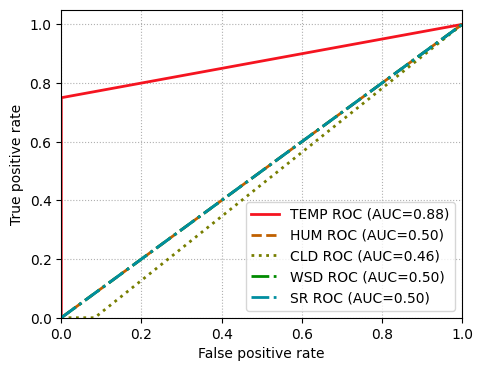

In [64]:
def mean_truth_accuracy(data,Task,subsize):
    mean_truth_accuracy = pd.DataFrame({'accuracy_'+Task:[0],'f1-score_'+Task:[0]})
    unknow_data = data.filter(regex=Task)
    bias = 2
    for i in range(20):
        if i % 2 == 0:
            unknow_data['mean_label'+str(int(i/2+1))]  = 0
            for j in range(len(data)):
                if (abs(unknow_data[Task+str(i+1)][j] - unknow_data[Task+str(i+1)].mean()) <= bias) and (abs(unknow_data[Task+str(i+2)][j] - unknow_data[Task+str(i+2)].mean()) <= bias):
                    unknow_data['mean_label'+str(int(i/2+1))][j] = 1
                else:
                    unknow_data['mean_label'+str(int(i/2+1))][j] = -1
    pred = unknow_data.filter(regex='mean')

    for t in range(10):
        y_pre = np.array(pred['mean_label'+str(t+1)]).reshape(-1).astype(int)
        mean_truth_accuracy.loc[t] = [accuracy_score(data['Label'],y_pre),f1_score(data['Label'],y_pre)]
    if Task == 'Humidity':Task = 'HUM'
    if Task == 'Cloud':Task = 'CLD'
    if Task == 'Wind-speed':Task = 'WSD'
    plot_roc(Task,data['Label'], y_pre,subsize)
    plt.savefig('3.svg',dpi=600,bbox_inches = 'tight')
    mean_truth_accuracy.index = mean_truth_accuracy.index + 1
    mean_truth_accuracy = mean_truth_accuracy.T
    mean_truth_accuracy.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return mean_truth_accuracy
plt.figure(figsize = (30,4))

mean_truth_accuracy(OW[0].loc[0:19],'TEMP',1).append(
    mean_truth_accuracy(OW[1].loc[0:19],'Humidity',1)).append(
    mean_truth_accuracy(OW[2].loc[0:19],'Cloud',1)).append(
    mean_truth_accuracy(OW[3].loc[0:19],'Wind-speed',1)).append(
    mean_truth_accuracy(OW[4].loc[0:19],'SR',1)).T

# 11. MV method

In [65]:
import time
start_time = time.time()
end_time = time.time()

def mv_truth_bias(gt_data,data,Task):
    bias_avg = 0
    data = data.filter(regex=Task)
    mv_truth_bias = pd.DataFrame({'Bias_'+Task:[0]})
    E = abs(gt_data - data.round().mode()) / gt_data
    for j in range(20):
        if j % 2 == 0:
            mv_truth_bias.loc[j] = (np.sum(E[Task+str(j+1)]) + np.sum(E[Task+str(j+2)])) / (len(E.dropna()) * 2)
    mv_truth_bias = mv_truth_bias.reset_index().drop('index',axis=1)
    mv_truth_bias.index = mv_truth_bias.index + 1
    mv_truth_bias = mv_truth_bias.T
    mv_truth_bias.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return mv_truth_bias
mv_execution_time = (end_time - start_time) * 1000
print("程序执行时间：", mv_execution_time, "毫秒")

mv_truth_bias(GT_fit[0],OW[0],'TEMP').append(mv_truth_bias(GT_fit[1],OW[1],'Humidity')
                                               .append(mv_truth_bias(GT_fit[2],OW[2],'Cloud')
                                                       .append(mv_truth_bias(GT_fit[3],OW[3],'Wind-speed')
                                                               .append(mv_truth_bias(GT_fit[4],OW[4],'SR'))))).T

程序执行时间： 0.049114227294921875 毫秒


,Bias_TEMP,Bias_Humidity,Bias_Cloud,Bias_Wind-speed,Bias_SR
t1,0.349336,0.303588,0.591957,0.324252,0.953156
t2,0.353338,0.420418,1.297611,0.888936,0.956906
t3,0.208631,0.023113,0.255566,0.143475,0.493630
t4,0.072880,0.031263,0.468124,0.833173,0.025058
t5,0.090029,0.032200,0.377982,0.208194,0.022045
t6,0.099417,0.023668,0.689999,0.273051,0.018636
t7,0.051742,0.020824,0.692380,0.325839,0.522639
t8,0.059594,0.047831,0.685118,0.264706,0.027634
t9,0.074622,0.028956,0.650679,0.210771,0.023041
t10,0.065664,0.292364,0.668349,0.603743,0.500388


[0. 1.] , [0. 1.]
[0.   0.25 1.  ] , [0. 0. 1.]
[0.         0.33333333 1.        ] , [0. 0. 1.]
[0. 1.] , [0. 1.]
[0.         0.70588235 1.        ] , [0. 0. 1.]


,accuracy_TEMP,f1-score_TEMP,accuracy_Humidity,f1-score_Humidity,accuracy_Cloud,f1-score_Cloud,accuracy_Wind-speed,f1-score_Wind-speed,accuracy_SR,f1-score_SR
t1,0.35,0.0,0.45,0.0,0.35,0.0,0.60,0.000000,0.25,0.0
t2,0.35,0.0,0.60,0.0,0.45,0.0,0.30,0.000000,0.25,0.0
t3,1.00,1.0,0.60,0.0,0.60,0.0,0.95,0.933333,0.25,0.0
t4,0.60,0.0,0.40,0.0,0.35,0.0,0.60,0.000000,0.25,0.0
t5,0.60,0.0,0.25,0.0,0.30,0.0,0.75,0.545455,0.25,0.0
t6,0.60,0.0,0.20,0.0,0.40,0.0,0.60,0.000000,0.25,0.0
t7,0.60,0.0,0.15,0.0,0.35,0.0,0.80,0.666667,0.25,0.0
t8,0.35,0.0,0.25,0.0,0.45,0.0,0.60,0.000000,0.25,0.0
t9,0.60,0.0,0.35,0.0,0.60,0.0,0.60,0.000000,0.25,0.0
t10,0.60,0.0,0.45,0.0,0.40,0.0,0.60,0.000000,0.25,0.0


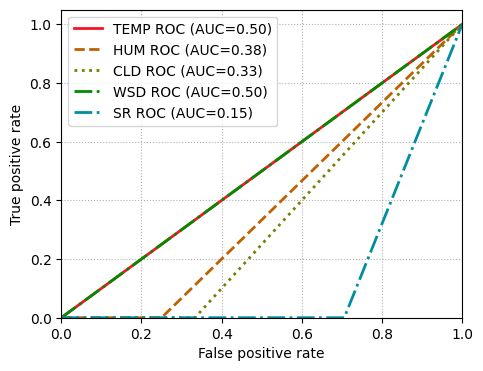

In [66]:
def mv_truth_accuracy(data,Task,subsize):
    mv_truth_accuracy = pd.DataFrame({'accuracy_'+Task:[0],'f1-score_'+Task:[0]})
    unknow_data = data.filter(regex=Task)
    bias = 2
    for i in range(20):
        if i % 2 == 0:
            unknow_data['mv_label'+str(int(i/2+1))]  = 0
            for j in range(len(data)):
                if (abs(unknow_data[Task+str(i+1)][j] - unknow_data[Task+str(i+1)].round().mode()[0]) <= bias) and (
                    abs(unknow_data[Task+str(i+2)][j] - unknow_data[Task+str(i+2)].round().mode()[0]) <= bias):
                    unknow_data['mv_label'+str(int(i/2+1))][j] = 1
                else:
                    unknow_data['mv_label'+str(int(i/2+1))][j] = -1
    pred = unknow_data.filter(regex='mv')

    for t in range(10):
        y_pre = np.array(pred['mv_label'+str(t+1)]).reshape(-1).astype(int)
        mv_truth_accuracy.loc[t] = [accuracy_score(data['Label'],y_pre),f1_score(data['Label'],y_pre)]
    if Task == 'Humidity':Task = 'HUM'
    if Task == 'Cloud':Task = 'CLD'
    if Task == 'Wind-speed':Task = 'WSD'
    plot_roc(Task,data['Label'], y_pre,subsize,'upper left')# The last time-step
    plt.savefig('4.svg',dpi=600,bbox_inches = 'tight')
    mv_truth_accuracy.index = mv_truth_accuracy.index + 1
    mv_truth_accuracy = mv_truth_accuracy.T
    mv_truth_accuracy.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return mv_truth_accuracy
plt.figure(figsize = (30,4))

mv_truth_accuracy(OW[0].loc[0:19],'TEMP',1).append(mv_truth_accuracy(OW[1].loc[0:19],'Humidity',1)).append(
    mv_truth_accuracy(OW[2].loc[0:19],'Cloud',1)).append(mv_truth_accuracy(OW[3].loc[0:19],'Wind-speed',1)).append(
    mv_truth_accuracy(OW[4].loc[0:19],'SR',1)).T

# 12. Median method

In [67]:
def median_truth_bias(gt_data,data,Task):
    bias_avg = 0
    data = data.filter(regex=Task)
    median_truth_bias = pd.DataFrame({'Bias_'+Task:[0]})
    E = abs(data - data.round().median()) / gt_data

    for j in range(20):
        if j % 2 == 0:
            median_truth_bias.loc[j] = (np.sum(E[Task+str(j+1)]) + np.sum(E[Task+str(j+2)])) / (len(E.dropna()) * 2)
    median_truth_bias = median_truth_bias.reset_index().drop('index',axis=1)
    median_truth_bias.index = median_truth_bias.index + 1
    median_truth_bias = median_truth_bias.T
    median_truth_bias.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return median_truth_bias

median_truth_bias(GT_fit[0],OW[0],'TEMP').append(median_truth_bias(GT_fit[1],OW[1],'Humidity')
                                               .append(median_truth_bias(GT_fit[2],OW[2],'Cloud')
                                                       .append(median_truth_bias(GT_fit[3],OW[3],'Wind-speed')
                                                               .append(median_truth_bias(GT_fit[4],OW[4],'SR')))))

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
Bias_TEMP,0.213645,0.221926,0.181790,0.149927,0.151924,0.152451,0.155218,0.149945,0.152018,0.150968
Bias_Humidity,0.210637,0.200470,0.161603,0.116909,0.112074,0.107143,0.105504,0.120248,0.108358,0.134314
Bias_Cloud,0.220927,0.226371,0.256668,0.309963,0.300010,0.304400,0.309997,0.336136,0.314078,0.332326
Bias_Wind-speed,0.555820,0.579787,0.497300,0.488342,0.493438,0.500046,0.504709,0.493303,0.477026,0.682984
Bias_SR,0.247168,0.246316,0.182337,0.117654,0.119121,0.122093,0.122631,0.125867,0.121991,0.212969


[0. 0. 1.] , [0. 1. 1.]
[0. 0. 1.] , [0.    0.375 1.   ]
[0.         0.16666667 1.        ] , [0. 0. 1.]
[0. 1.] , [0. 1.]
[0.         0.70588235 1.        ] , [0. 0. 1.]


,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
accuracy_TEMP,1.00,0.950000,1.000000,0.950000,0.950000,0.900000,1.000000,1.000000,1.000000,1.000000
f1-score_TEMP,1.00,0.933333,1.000000,0.933333,0.933333,0.857143,1.000000,1.000000,1.000000,1.000000
accuracy_Humidity,0.60,0.800000,0.650000,0.700000,0.800000,0.750000,0.800000,0.750000,0.750000,0.750000
f1-score_Humidity,0.00,0.666667,0.222222,0.400000,0.666667,0.545455,0.666667,0.545455,0.545455,0.545455
accuracy_Cloud,0.50,0.400000,0.400000,0.400000,0.450000,0.350000,0.350000,0.550000,0.500000,0.500000
f1-score_Cloud,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
accuracy_Wind-speed,0.60,0.600000,0.850000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
f1-score_Wind-speed,0.00,0.000000,0.769231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
accuracy_SR,0.25,0.250000,0.250000,0.250000,0.300000,0.250000,0.250000,0.250000,0.300000,0.250000
f1-score_SR,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


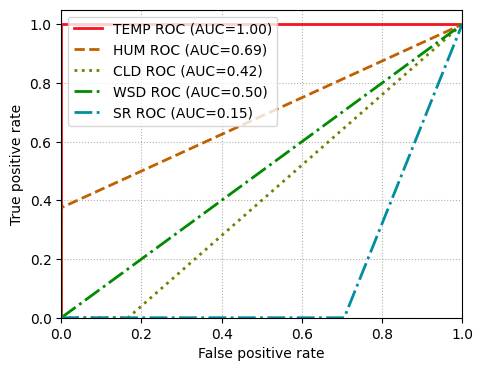

In [68]:
def median_truth_accuracy(data,Task,subsize):
    median_truth_accuracy = pd.DataFrame({'accuracy_'+Task:[0],'f1-score_'+Task:[0]})
    unknow_data = data.filter(regex=Task)
    bias = 2
    for i in range(20):
        if i % 2 == 0:
            unknow_data['mv_label'+str(int(i/2+1))]  = 0
            for j in range(len(data)):
                if (abs(unknow_data[Task+str(i+1)][j] - unknow_data[Task+str(i+1)].round().median()) <= bias) and (
                    abs(unknow_data[Task+str(i+2)][j] - unknow_data[Task+str(i+2)].round().median()) <= bias):
                    unknow_data['mv_label'+str(int(i/2+1))][j] = 1
                else:
                    unknow_data['mv_label'+str(int(i/2+1))][j] = -1
    pred = unknow_data.filter(regex='mv')

    for t in range(10):
        y_pre = np.array(pred['mv_label'+str(t+1)]).reshape(-1).astype(int)
        median_truth_accuracy.loc[t] = [accuracy_score(data['Label'],y_pre),f1_score(data['Label'],y_pre)]
    if Task == 'Humidity':Task = 'HUM'
    if Task == 'Cloud':Task = 'CLD'
    if Task == 'Wind-speed':Task = 'WSD'
    plot_roc(Task,data['Label'], y_pre,subsize,'upper left')# The last time-step
    plt.savefig('5.svg',dpi=600,bbox_inches = 'tight')
    median_truth_accuracy.index = median_truth_accuracy.index + 1
    median_truth_accuracy = median_truth_accuracy.T
    median_truth_accuracy.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return median_truth_accuracy
plt.figure(figsize = (30,4))

median_truth_accuracy(OW[0].loc[0:19],'TEMP',1).append(median_truth_accuracy(OW[1].loc[0:19],'Humidity',1)).append(
    median_truth_accuracy(OW[2].loc[0:19],'Cloud',1)).append(median_truth_accuracy(OW[3].loc[0:19],'Wind-speed',1)).append(
    median_truth_accuracy(OW[4].loc[0:19],'SR',1))

# 13. GD method

In [69]:
import time
start_time = time.time()
end_time = time.time()

A = TPA_TEMP[TPA_TEMP['Label'] == 1]
B = OW_HUM[OW_HUM['Worker'].isin(A['Worker'])]
C = OW_CLD[OW_CLD['Worker'].isin(A['Worker'])]
D = OW_WSD[OW_WSD['Worker'].isin(A['Worker'])]
E = OW_SR[OW_SR['Worker'].isin(A['Worker'])]

def gd_truth_bias(gt_data,data,Task):
    bias_avg = 0
    data = data.filter(regex=Task)
    gd_truth_bias = pd.DataFrame({'Bias_'+Task:[0]})
    E = abs(gt_data - data) / gt_data
    for j in range(20):
        if j % 2 == 0:
            gd_truth_bias.loc[j] = (np.sum(E[Task+str(j+1)]) + np.sum(E[Task+str(j+2)])) / (len(E.dropna()) * 2)
    gd_truth_bias = gd_truth_bias.reset_index().drop('index',axis=1)
    gd_truth_bias.index = gd_truth_bias.index + 1
    gd_truth_bias = gd_truth_bias.T
    gd_truth_bias.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return gd_truth_bias
gd_execution_time = (end_time - start_time) * 1000
print("程序执行时间：", gd_execution_time, "毫秒")

gd_truth_bias(GT_fit[0],A,'TEMP').append(gd_truth_bias(GT_fit[1],B,'Humidity')
                                               .append(gd_truth_bias(GT_fit[2],C,'Cloud')
                                                       .append(gd_truth_bias(GT_fit[3],D,'Wind-speed')
                                                               .append(gd_truth_bias(GT_fit[4],E,'SR'))))).T

程序执行时间： 0.056743621826171875 毫秒


,Bias_TEMP,Bias_Humidity,Bias_Cloud,Bias_Wind-speed,Bias_SR
t1,0.037343,0.075,0.25,0.375,0.131818
t2,0.036954,0.075,0.25,0.375,0.131818
t3,0.031405,0.075,0.25,0.375,0.131818
t4,0.033285,0.075,0.25,0.375,0.131818
t5,0.034840,0.075,0.25,0.375,0.131818
t6,0.043620,0.075,0.25,0.375,0.131818
t7,0.028423,0.075,0.25,0.375,0.131818
t8,0.032740,0.075,0.25,0.375,0.131818
t9,0.034417,0.075,0.25,0.375,0.131818
t10,0.039371,0.075,0.25,0.375,0.131818


[0. 0. 1.] , [0. 1. 1.]
[0.   0.25 1.  ] , [0.    0.625 1.   ]
[0.   0.25 1.  ] , [0.    0.625 1.   ]
[0.   0.25 1.  ] , [0.    0.625 1.   ]
[0.         0.47058824 1.        ] , [0. 0. 1.]


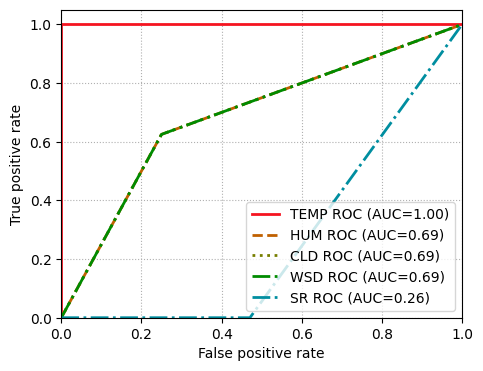

In [70]:
reliable_TEMP = OW_TEMP[OW_TEMP['Worker'].isin(A['Worker'])]
reliable_TEMP['Label'] = 1
unreliable_TEMP = OW_TEMP[~OW_TEMP['Worker'].isin(A['Worker'])]
unreliable_TEMP['Label'] = -1
UNK_TEMP = reliable_TEMP.append(unreliable_TEMP).sort_index()

reliable_HUM = OW_HUM[OW_HUM['Worker'].isin(A['Worker'])]
reliable_HUM['Label'] = 1
unreliable_HUM = OW_HUM[~OW_HUM['Worker'].isin(A['Worker'])]
unreliable_HUM['Label'] = -1
UNK_HUM = reliable_HUM.append(unreliable_HUM).sort_index()

reliable_CLD = OW_CLD[OW_CLD['Worker'].isin(A['Worker'])]
reliable_CLD['Label'] = 1
unreliable_CLD = OW_CLD[~OW_CLD['Worker'].isin(A['Worker'])]
unreliable_CLD['Label'] = -1
UNK_CLD = reliable_CLD.append(unreliable_CLD).sort_index()

reliable_WSD = OW_WSD[OW_WSD['Worker'].isin(A['Worker'])]
reliable_WSD['Label'] = 1
unreliable_WSD = OW_WSD[~OW_WSD['Worker'].isin(A['Worker'])]
unreliable_WSD['Label'] = -1
UNK_WSD = reliable_WSD.append(unreliable_WSD).sort_index()

reliable_SR = OW_SR[OW_SR['Worker'].isin(A['Worker'])]
reliable_SR['Label'] = 1
unreliable_SR = OW_SR[~OW_SR['Worker'].isin(A['Worker'])]
unreliable_SR['Label'] = -1
UNK_SR = reliable_SR.append(unreliable_SR).sort_index()

plt.figure(figsize = (30,4))
plot_roc('TEMP',OW[0].loc[0:19,'Label'], UNK_TEMP[0:20]['Label'],1)
plot_roc('HUM',OW[1].loc[0:19,'Label'], UNK_HUM[0:20]['Label'],1)
plot_roc('CLD',OW[2].loc[0:19,'Label'], UNK_CLD[0:20]['Label'],1)
plot_roc('WSD',OW[3].loc[0:19,'Label'], UNK_WSD[0:20]['Label'],1)
plot_roc('SR',OW[4].loc[0:19,'Label'], UNK_SR[0:20]['Label'],1)
plt.savefig('6.svg',dpi=600,bbox_inches = 'tight')

In [71]:
def gd_truth_accuracy(GT_data,UNK_data,Task):
    gd_truth_accuracy = pd.DataFrame({'accuracy_'+Task:[0],'f1-score_'+Task:[0]})
    unknow_data = UNK_data.filter(regex=Task)
    for t in range(10):
        gd_truth_accuracy.loc[t] = [accuracy_score(GT_data['Label'],UNK_data['Label']),f1_score(GT_data['Label'],UNK_data['Label'])]
    gd_truth_accuracy.index = gd_truth_accuracy.index + 1
    gd_truth_accuracy = gd_truth_accuracy.T
    gd_truth_accuracy.columns = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
    return gd_truth_accuracy
gd_truth_accuracy(OW[0].loc[0:19],UNK_TEMP[0:20],'TEMP').append(gd_truth_accuracy(OW[1].loc[0:19],UNK_HUM[0:20],'Humidity')).append(
    gd_truth_accuracy(OW[2].loc[0:19],UNK_CLD[0:20],'Cloud')).append(gd_truth_accuracy(OW[3].loc[0:19],UNK_WSD[0:20],'Wind-speed')).append(
    gd_truth_accuracy(OW[4].loc[0:19],UNK_SR[0:20],'SR')).T

,accuracy_TEMP,f1-score_TEMP,accuracy_Humidity,f1-score_Humidity,accuracy_Cloud,f1-score_Cloud,accuracy_Wind-speed,f1-score_Wind-speed,accuracy_SR,f1-score_SR
t1,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t2,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t3,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t4,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t5,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t6,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t7,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t8,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t9,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0
t10,1.0,1.0,0.7,0.625,0.7,0.625,0.7,0.625,0.45,0.0


# Not datasets testing

In [72]:
#mean temp
import numpy as np
gd_data = np.array([
[25.03,26.02,24.08,25.03,26.01],
[25.01,25.98,24.05,25.21,25.85],
[25.03,26.02,24.05,26.21,25.01],
[25.01,25.98,24.08,25.25,25.28],
[25.03,26.01,24.10,25.35,25.28]]
)

worker_report = np.array([
[25.03,26.02,24.08,25.03,26.01],
[27.88,28.32,26.7,28.83,30.21],
[25.03,26.02,24.05,25.25,26.82],
[27.98,28.98,26.78,28.85,30.26],
[27.21,28.21,26.54,28.68,30.26]
])

list_data = []
#mean
for i in range(5):
    list_data.append(abs(gd_data[:,i] - worker_report[:,i].mean()) / gd_data[:,i])
for i in range(5):
    print(sum(list_data[i]) )


0.32051876013477876
0.28998032350753183
0.3236159500995944
0.37880422637849065
0.634138568212712


In [73]:
#MV temp
list_data2 = []
for i in range(5):
    list_data2.append(abs(gd_data[:,i] - np.argmax(np.bincount(list(worker_report[:,i])))) / gd_data[:,i])
for i in range(5):
    print(sum(list_data2[i]))


0.3952530054698054
0.3842038916107191
0.40046877497422706
0.5110699040763218
0.8868820370013011


In [74]:
#GD temp
list_data3 = []
b = np.isin(worker_report,gd_data)
print(b)

worker_report2 = np.array([
[25.03,26.02,24.08,25.03,26.01],
[25.01,25.98,24.05,25.21,25.85],
[25.03,26.02,24.05,26.21,26.82],
[25.01,25.98,24.08,25.25,25.28],
[25.03,26.01,24.10,25.35,25.28]]
)

for i in range(5):
    list_data3.append(abs(gd_data[:,i] - worker_report2[:,i])  / gd_data[:,i])
for i in range(5):
    print(sum(list_data3[i]))

[[ True  True  True  True  True]
 [False False False False False]
 [ True  True  True  True False]
 [False False False False False]
 [False False False False False]]
0.0
0.0
0.0
0.0
0.0723710515793682


In [75]:
#mean water-level
import numpy as np
gd_data = np.array([
[150.23,160.01,150.28,150.55,160.23],
[150.13,159.23,151.30,149.89,161.08],
[152.56,160.33,151.02,151.22,160.33],
[150.33,159.53,151.73,150.78,159.45],
[153.45,161.33,149.23,150.01,159.75],
])


worker_report = np.array([
[155.23,165.01,155.28,155.55,165.23],
[170.22,175.31,170.25,174.31,175.85],
[171.13,160.33,151.02,151.22,160.33],
[165.13,169.23,171.30,169.89,171.08],
[150.23,159.53,151.02,149.89,159.45],
]
)


list_data = []
#mean
for i in range(5):
    list_data.append(abs(gd_data[:,i] - worker_report[:,i].mean()) / gd_data[:,i])
for i in range(5):
    print(sum(list_data[i]))


0.3654562252100346
0.18113475350128036
0.3008204282326883
0.3217393901439223
0.1942338915278225


In [76]:
#MV water-level
list_data_water = []
for i in range(5):
    list_data_water.append(abs(gd_data[:,i] - np.argmax(np.bincount(list(worker_report[:,i])))) / gd_data[:,i])

for i in range(5):
    print(sum(list_data_water[i]) )


0.04385524927023442
0.03381665396665368
0.02357836871348491
0.04945203199407865
0.036401731176985405


In [77]:
#GD water-level
list_data3 = []
worker_report2 = np.array([
[155.23,165.01,155.28,155.55,165.23],
[150.13,159.23,151.30,149.89,161.08],
[171.13,160.33,151.02,151.22,160.33],
[150.33,159.53,151.73,150.78,159.45],
[150.23,159.53,151.02,149.89,159.45],
]
)
for i in range(5):
    list_data3.append(abs(gd_data[:,i] - worker_report2[:,i]) / gd_data[:,i] )
for i in range(5):
    print(sum(list_data3[i] ))


0.17598893530375925
0.042405302312255214
0.04526613423309672
0.03401150429227449
0.033083076879802255


In [78]:
#TPAAD water-level
list_data3 = []
worker_report2 = np.array([
[150.23,160.01,150.28,150.55,160.23],
[150.13,159.23,151.30,149.89,161.08],
[171.13,160.33,151.02,151.22,160.33],
[150.33,159.53,151.73,150.78,159.45],
[150.23,159.53,151.02,149.89,159.45],
]
)
for i in range(5):
    list_data3.append(abs(gd_data[:,i] - worker_report2[:,i]) / gd_data[:,i] )
for i in range(5):
    print(sum(list_data3[i] ))


0.14270663483115056
0.011157255315192531
0.011994907190243386
0.0007999466702220155
0.0018779342723005406
